In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import proplot as pplt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import gym_bart
import itertools
from umap import UMAP
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors
)
from model_evaluation import (
    forced_action_evaluate, 
    meta_bart_callback,
    meta_bart_multi_callback,
    reshape_parallel_evalu_res,
    forced_action_evaluate_multi,
)
from bart_behavior_analysis import (
    plot_1color5fsize,
    plot_1colornfsize,
    pop_behavior
)
from bart_single_node_responses import *
from read_experiments import average_runs, load_exp_df
import re

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env
import pickle
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path

from bart_representation_analysis import *
from bart_compress_visualize_decode import *
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind

from diptest import diptest
from scipy.stats import pearsonr
set_rc()

from plotting_utils import *

In [9]:
res = pickle.load(open('data/meta_representation_results', 'rb')) # arrays
ares = pickle.load(open('data/meta_rnn_gradients', 'rb')) # dicts
forced_ares = pickle.load(open('data/meta_rnn_forced_gradients', 'rb')) # dicts
node_ares = pickle.load(open('data/meta_single_node_characteristics', 'rb')) # arrays
summary = pickle.load(open('data/meta_summary', 'rb'))
shape = (2, 4, 5, 10)

In [498]:
print('res (general)')
print(np.array(list(res.keys())))
print('ares (activations)')
print(np.array(list(ares.keys())))
print('forced_ares (meta clustering)')
print(np.array(list(forced_ares.keys())))
print('node_ares (single node character)')
print(np.array(list(node_ares.keys())))
print('summary')
print(np.array(list(summary.keys())))

res (general)
['last_sizes' 'unpopped_sizes' 'pop_rate' 'rewards' 'values'
 'action_probs' 'all_lens' 'all_num_balloons' 'balloon_steps'
 'button_presses' 'dec_flow_scores' 'iterators_idxs' 'sizes' 'ramp_f1s'
 'ramp_indiv_contribs' 'confidence_scores' 'unconfidence_scores'
 'unconfident_points' 'step_count' 'all_decision_nodes'
 'cluster_regressor_coefs' 'cluster_regressor_scores' 'cluster_ks'
 'pca_regressor_coefs' 'pca_regressor_scores']
ares (activations)
['cluster_activations' 'cluster_labels' 'cluster_orientations'
 'rnn_hx_influences' 'val_grads' 'action_grads' 'all_rnn_hxs'
 'all_ep_lens' 'all_obs' 'rnn_hx_influences2']
forced_ares (meta clustering)
['cluster_activations' 'rnn_hx_influences' 'val_grads' 'action_grads'
 'all_rnn_hxs' 'fixprev_res' 'give_res' 'res' 'all_oriented_cactiv'
 'per_agent_labels' 'per_agent_orientations' 'per_agent_cdists' 'labels'
 'orientations' 'kmeans' 'cdists' 'node_kmeans' 'agent_node_meta_labels'
 'agent_node_meta_orientation' 'per_agent_action_gr

# 0. General Performance

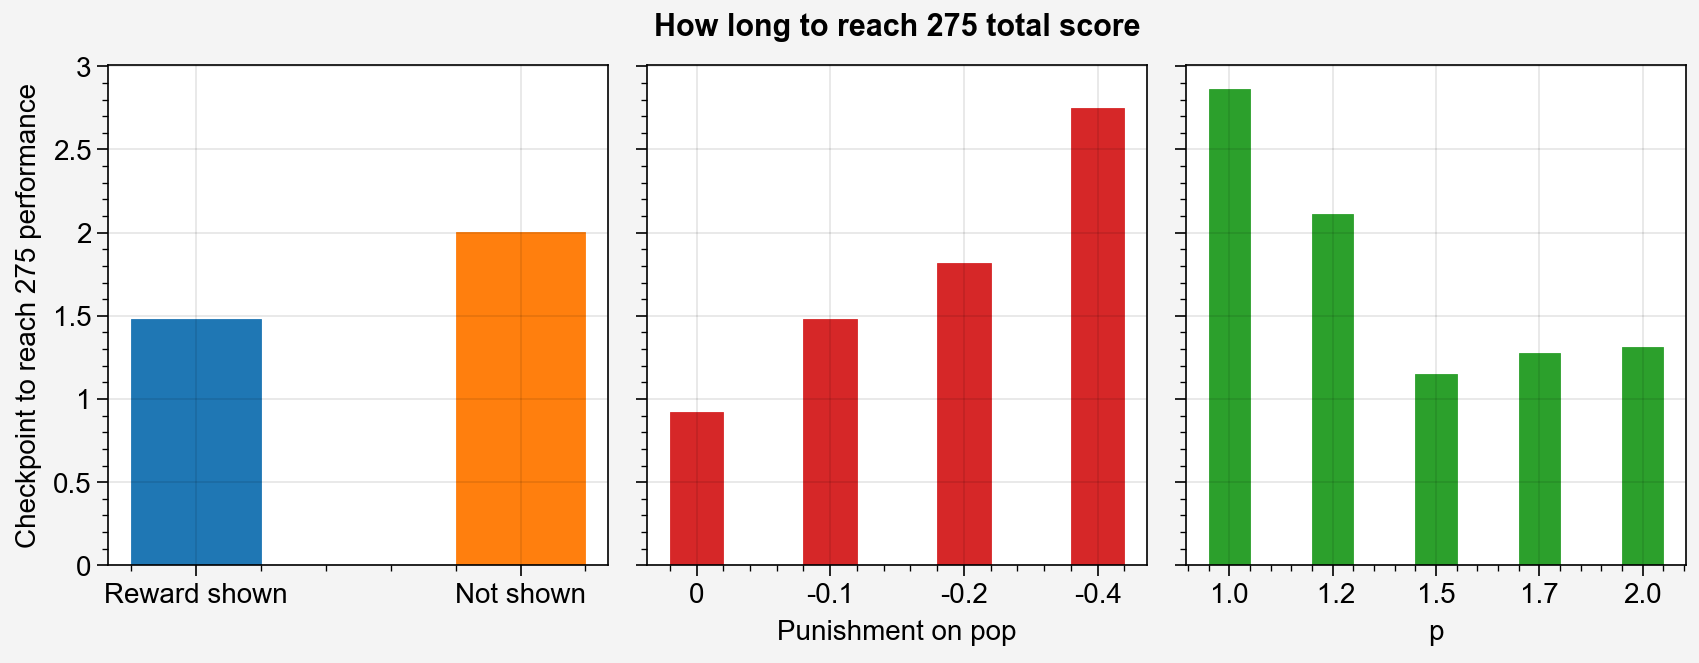

In [4]:
first_idxs = pickle.load(open('data/meta_representation_first_idxs', 'rb'))
fig, ax = pplt.subplots(ncols=3, sharex=False)
for i in range(2):
    s = len(first_idxs[i].reshape(-1))
    ax[0].bar([i], first_idxs[i].reshape(-1).mean(), c=rgb_colors[i])
    ax[0].format(xlocator=range(2), xformatter=give_labels)
for i in range(4):
    s = len(first_idxs[:, i].reshape(-1))
    ax[1].bar([i], first_idxs[:, i].reshape(-1).mean(), c=rgb_colors[3])
    ax[1].format(xlocator=range(6), xformatter=pop_labels, xlabel=pop_axis)
for i in range(5):
    s = len(first_idxs[:, :, i].reshape(-1))
    ax[2].bar([i], first_idxs[:, :, i].reshape(-1).mean(), c=rgb_colors[2])
    ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)

ax.format(ylabel='Checkpoint to reach 275 performance',
          suptitle='How long to reach 275 total score')

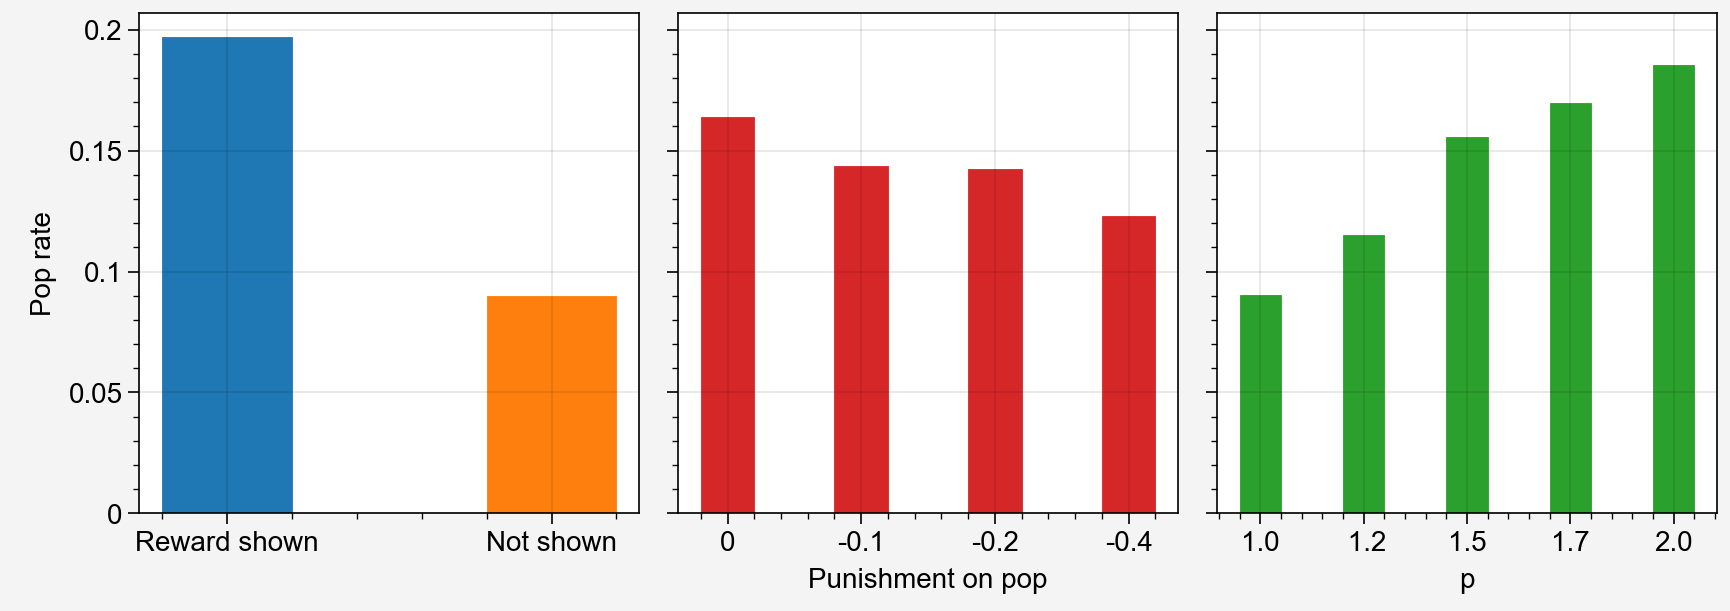

In [5]:
fig, ax = pplt.subplots(ncols=3, sharex=False)
for h in range(2):
    idxs = select_chks_by_dimension(h=h, with_chk=True)
    pop_rates = []
    for idx in idxs:
        pop_rates.append(res['pop_rate'][idx].mean())
    ax[0].bar(h, np.mean(pop_rates), c=rgb_colors[h])
for i in range(4):
    idxs = select_chks_by_dimension(i=i, with_chk=True)
    pop_rates = []
    for idx in idxs:
        pop_rates.append(res['pop_rate'][idx].mean())
    ax[1].bar(i, np.mean(pop_rates), c=rgb_colors[3])
for j in range(5):
    idxs = select_chks_by_dimension(j=j, with_chk=True)
    pop_rates = []
    for idx in idxs:
        pop_rates.append(res['pop_rate'][idx].mean())
    ax[2].bar(j, np.mean(pop_rates), c=rgb_colors[2])

    
ax[0].format(xlocator=range(2), xformatter=give_labels, ylabel='Pop rate')
ax[1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis)
ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)
    

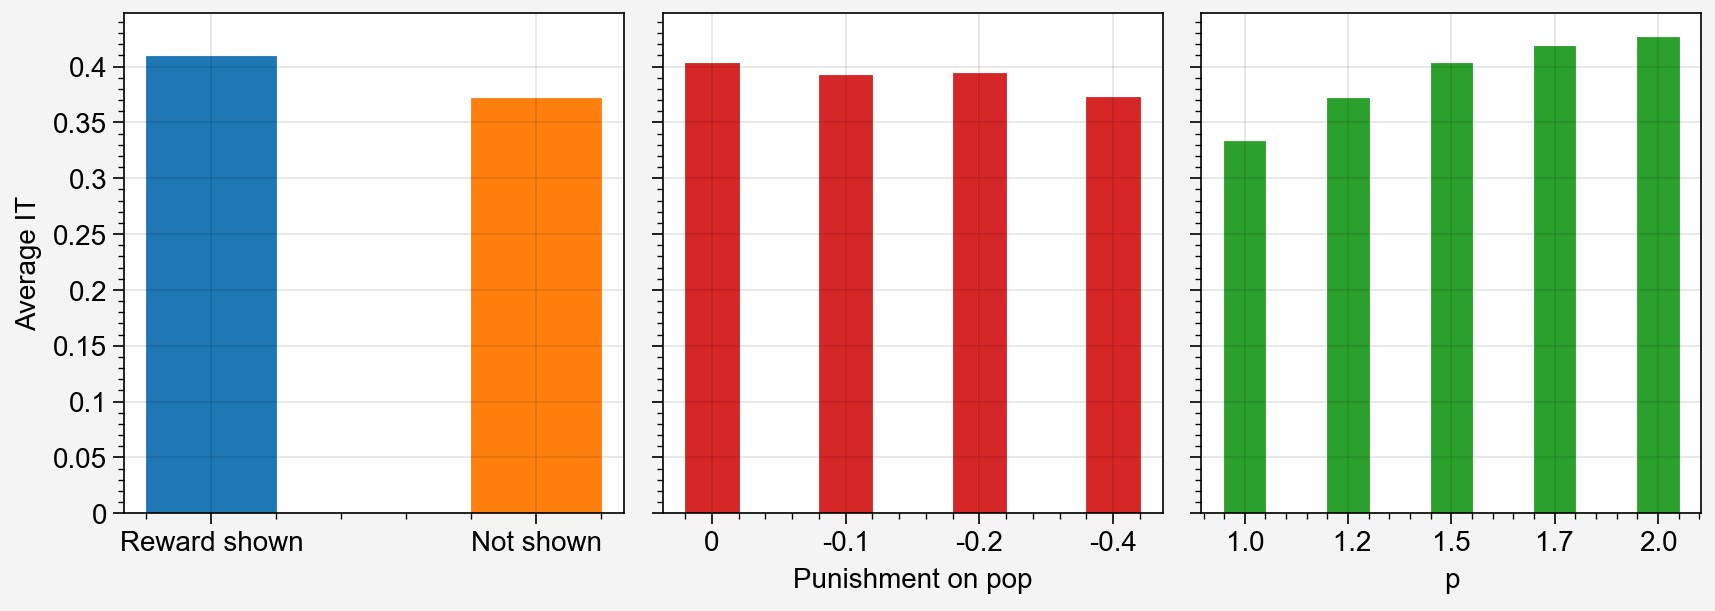

In [6]:
fig, ax = pplt.subplots(ncols=3, sharex=False)
for h in range(2):
    idxs = select_chks_by_dimension(h=h, with_chk=True)
    avg_its = []
    for idx in idxs:
        avg_its.append(res['unpopped_sizes'][idx].mean(axis=1))
    ax[0].bar(h, np.mean(avg_its), c=rgb_colors[h])
for i in range(4):
    idxs = select_chks_by_dimension(i=i, with_chk=True)
    avg_its = []
    for idx in idxs:
        avg_its.append(res['unpopped_sizes'][idx].mean(axis=1))
    ax[1].bar(i, np.mean(avg_its), c=rgb_colors[3])
for j in range(5):
    idxs = select_chks_by_dimension(j=j, with_chk=True)
    avg_its = []
    for idx in idxs:
        avg_its.append(res['unpopped_sizes'][idx].mean(axis=1))
    ax[2].bar(j, np.mean(avg_its), c=rgb_colors[2])
    
ax[0].format(xlocator=range(2), xformatter=give_labels, ylabel='Average IT')
ax[1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis)
ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)

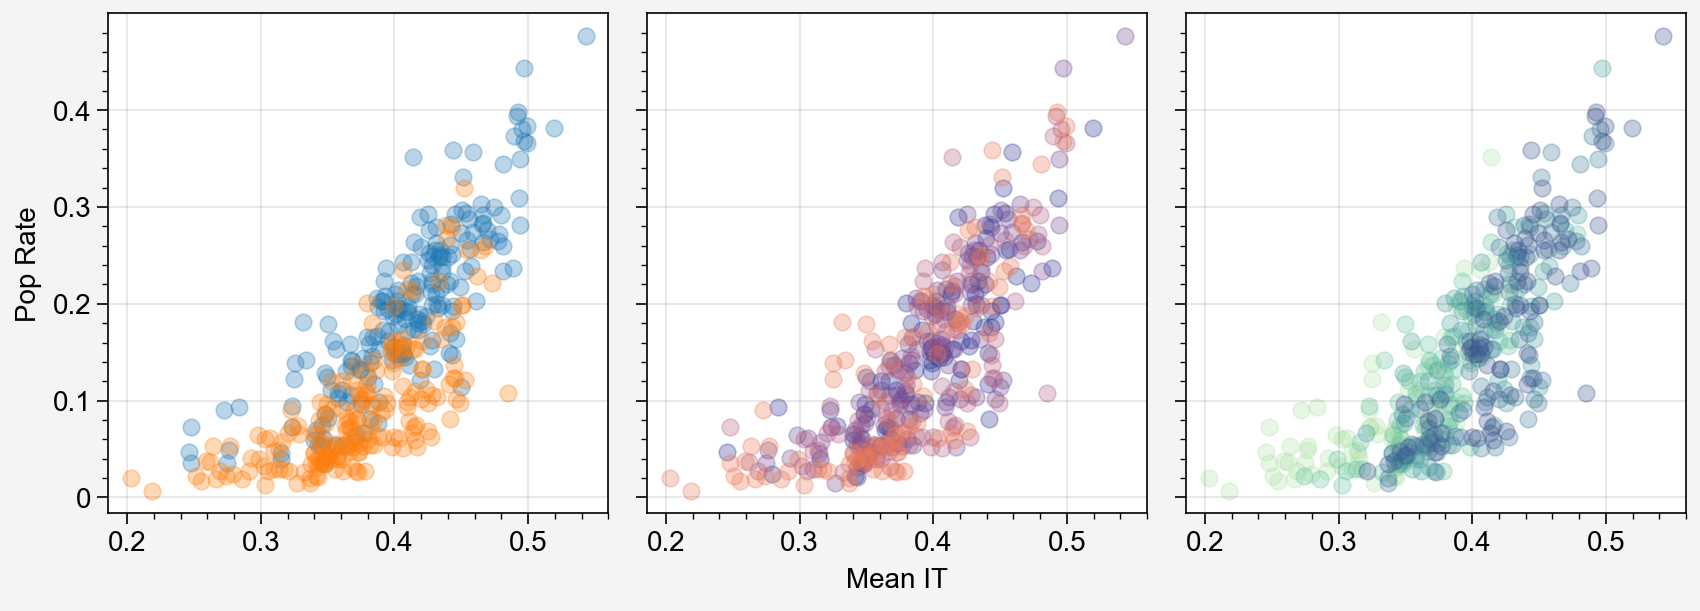

In [37]:
fig, ax = pplt.subplots(ncols=3)

for h in range(2):
    idxs = select_chks_by_dimension(h=h, with_chk=True)
    avg_its = []
    pop_rates = []
    for idx in idxs:
        avg_its.append(res['unpopped_sizes'][idx].mean())
        pop_rates.append(res['pop_rate'][idx].mean())
    ax[0].scatter(avg_its, pop_rates, c=rgb_colors[h], alpha=0.3)
for i in range(4):
    idxs = select_chks_by_dimension(i=i, with_chk=True)
    avg_its = []
    pop_rates = []
    for idx in idxs:
        avg_its.append(res['unpopped_sizes'][idx].mean())
        pop_rates.append(res['pop_rate'][idx].mean())
    c = get_color_from_colormap(i, -1, 5, 'thermal')
    ax[1].scatter(avg_its, pop_rates, c=c, alpha=0.3)
for j in range(5):
    idxs = select_chks_by_dimension(j=j, with_chk=True)
    avg_its = []
    pop_rates = []
    for idx in idxs:
        avg_its.append(res['unpopped_sizes'][idx].mean())
        pop_rates.append(res['pop_rate'][idx].mean())
    c = get_color_from_colormap(j, -1, 6, 'deep')
    ax[2].scatter(avg_its, pop_rates, c=c, alpha=0.3)

ax.format(xlabel='Mean IT', ylabel='Pop Rate')

Text(0.3, 0.3, '$R^2$=0.63')

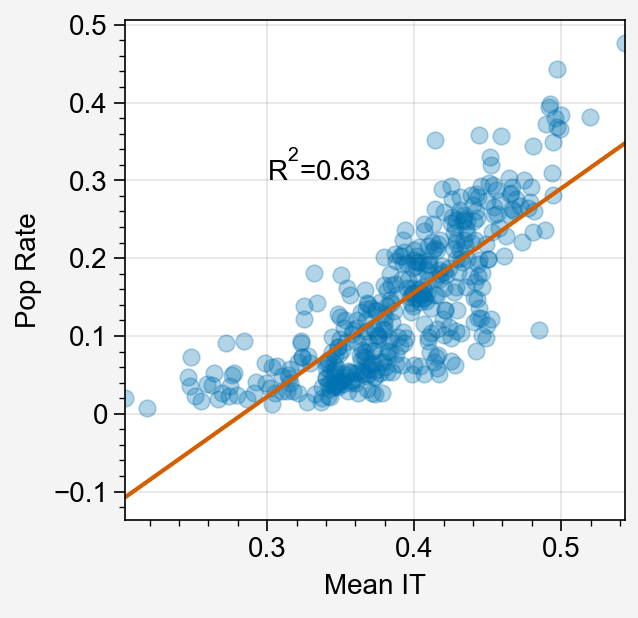

In [46]:
idxs = select_chks_by_dimension(with_chk=True)
sizes = [res['unpopped_sizes'][idx].mean() for idx in idxs]
pop_rates = [res['pop_rate'][idx].mean() for idx in idxs]
fig, ax = pplt.subplots()
ax.scatter(sizes, pop_rates, alpha=0.3)
ax.format(xlabel='Mean IT', ylabel='Pop Rate')
(m, b), r2 = linear_best_fit(np.array(sizes), np.array(pop_rates))
x = np.array([min(sizes), max(sizes)])
ax.plot(x, m*x+b)
ax.text(0.3, 0.3, f'$R^2$={r2:.2f}')

## 0.1 Combine Data Plot

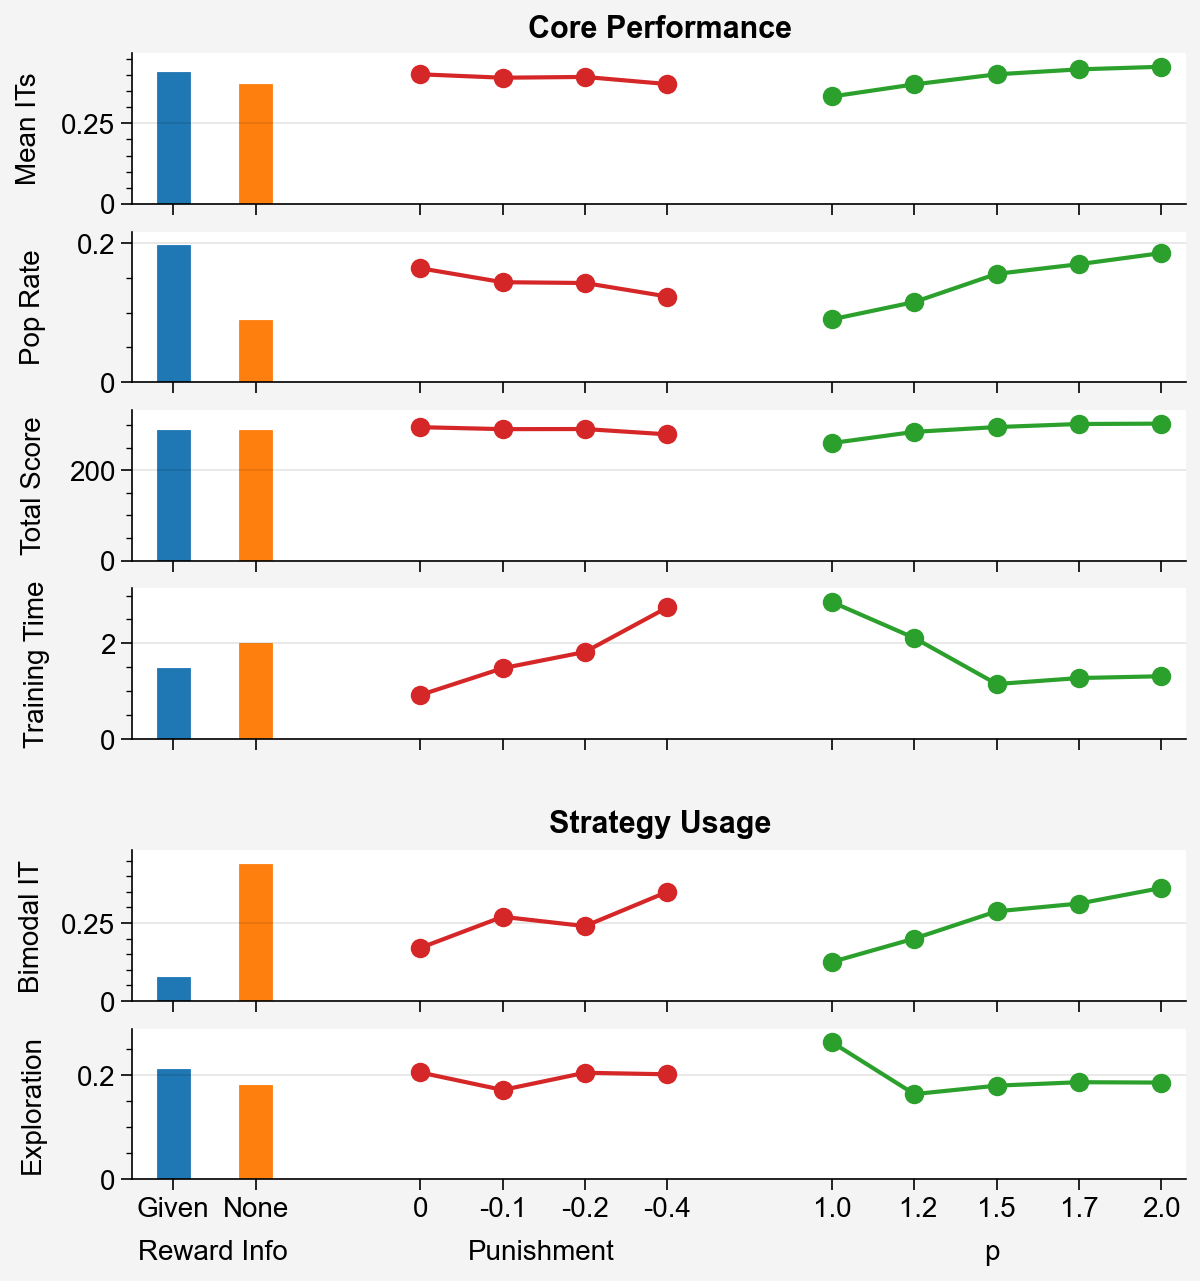

In [584]:

plot_keys = ['mean_its', 'pop_rate', 'total_score', 'first_chks',
             'bimodal_its', 'gradual_exploration']
plot_labels = ['Mean ITs', 'Pop Rate', 'Total Score', 'Training Time',
               'Bimodal IT', 'Exploration']
ylabelpads = [7, 11, 8, 18, 6, 11]
fig, ax = pplt.subplots(nrows=len(plot_keys), sharex=True, sharey=False, 
                        figwidth=6, refaspect=7, hspace=(1, 1, 1, 4, 1))
for m in range(len(plot_keys)):
    key = plot_keys[m]
    for h in range(2):
        ax[m].bar(h, summary[key][h].mean(), c=rgb_colors[h])
        
    ax[m].plot(np.arange(3, 7), summary[key].mean(axis=(0, 2, 3)),
               c=rgb_colors[3], marker='o')
    ax[m].plot(np.arange(8, 13), summary[key].mean(axis=(0, 1, 3)),
               c=rgb_colors[2], marker='o')
    
    ax[m].format(xgrid=False, ylabel=plot_labels[m],
                 ylabelpad=ylabelpads[m])
    ax[m].spines['top'].set_visible(False)
    ax[m].spines['right'].set_visible(False)
    
ax.format(xlocator=[0, 1,  3, 4, 5, 6,  8, 9, 10, 11, 12],
          xformatter=['Given', 'None']+pop_labels+p_labels,
          xlim=[-0.5, 12.3], xtickminor=False, ymargin=0.1)
fig.text(0.115, 0.017, 'Reward Info')
fig.text(0.39, 0.017, 'Punishment')
fig.text(0.82, 0.017, '$p$')

fig.text(0.55, 0.97, 'Core Performance', fontweight='bold', ha='center',
            fontsize=11)
fig.text(0.55, 0.35, 'Strategy Usage', fontweight='bold', ha='center',
            fontsize=11)
 
fig.savefig('plots/testrows.png')

# 1. Behavioral Strategies

## 1.1 Training condition behavioral plots

c:\Users\14and\Desktop\Work\github\bart_ppo\write_and_test\bart_representation_analysis.py:640: RuntimeWarning: divide by zero encountered in scalar divide
  r2 = 1 - ss_res / ss_tot


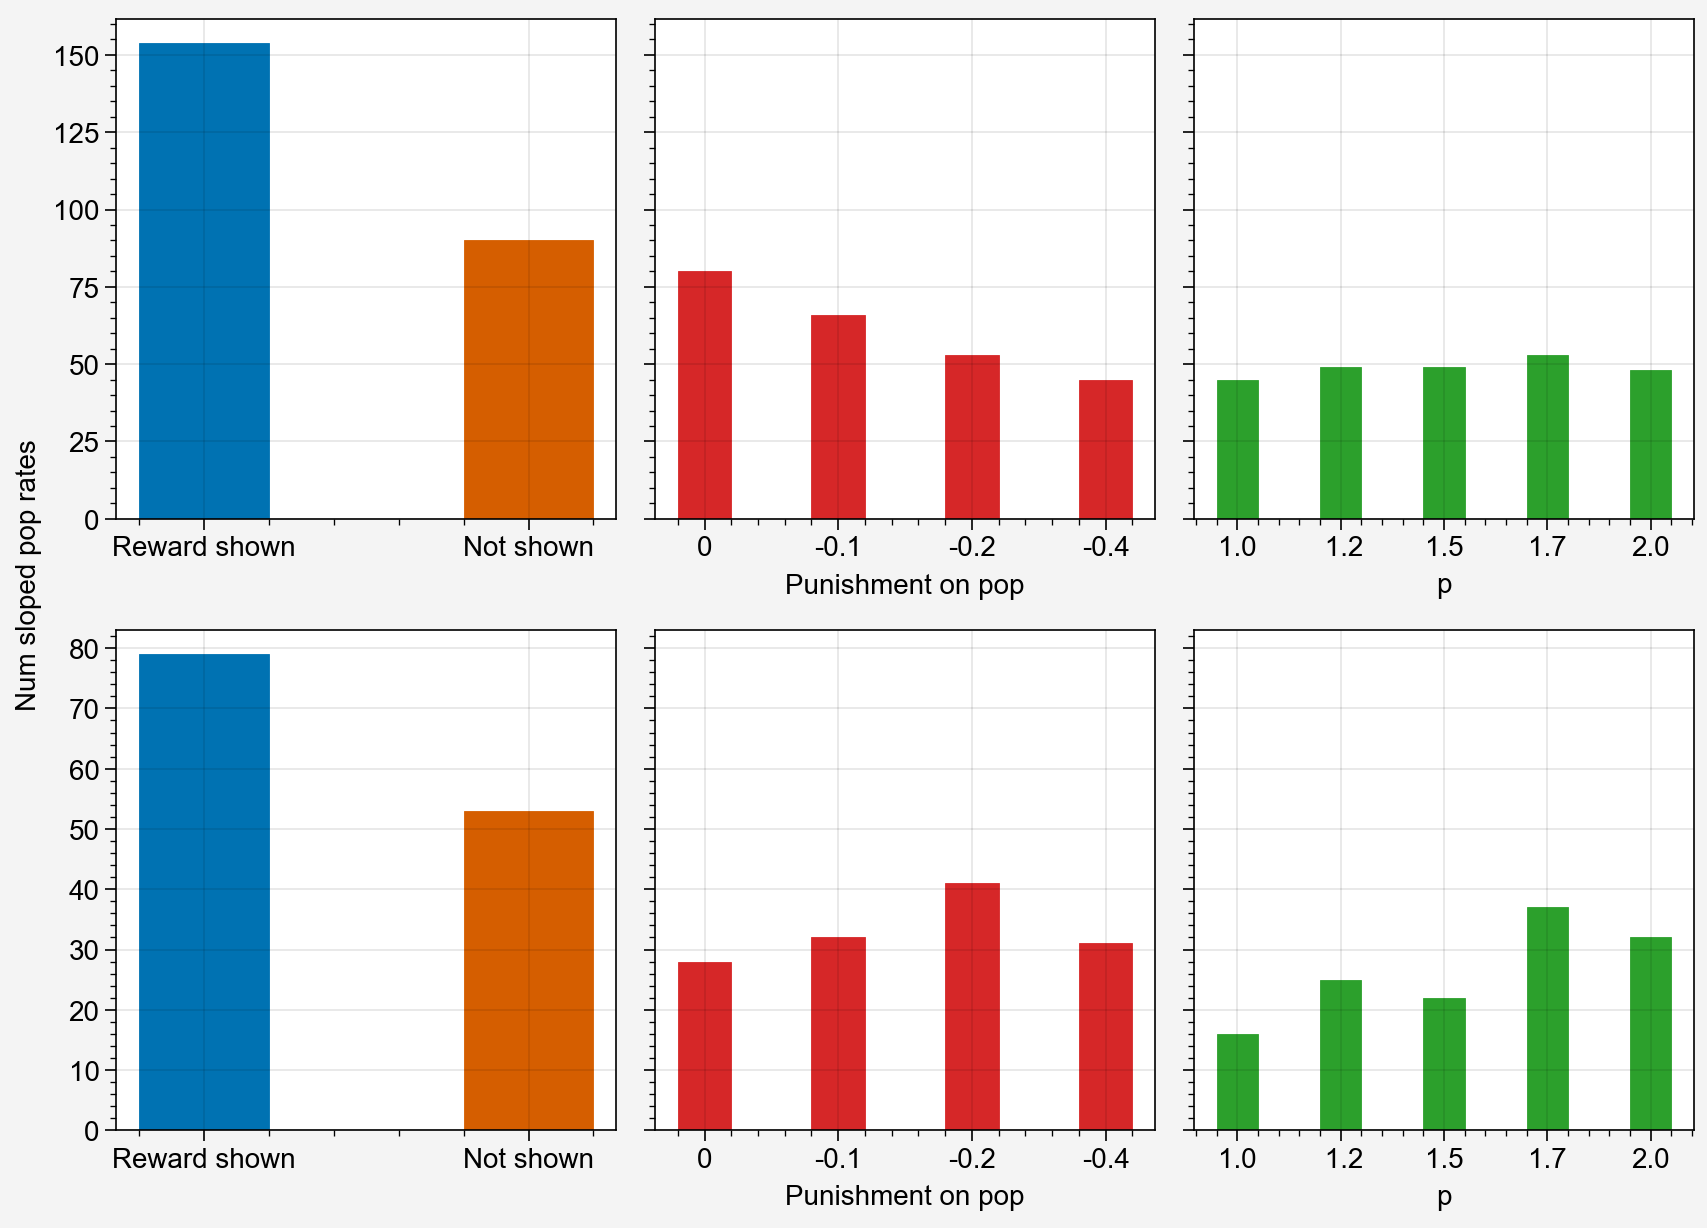

In [49]:
fig, ax = pplt.subplots(ncols=3, nrows=2, sharex=False)
for h in range(2):
    idxs = select_chks_by_dimension(h=h, with_chk=True)
    num_sloped = 0
    num_peak = 0
    for idx in idxs:
        p = res['pop_rate'][idx]
        slope, has_peak = pop_behavior(p, ret_plot=False)
        sloped = slope < -0.4
        num_sloped += sloped*1
        num_peak += has_peak*1
    ax[0, 0].bar(h, np.mean(num_sloped))
    ax[1, 0].bar(h, np.mean(num_peak))
for i in range(4):
    idxs = select_chks_by_dimension(i=i, with_chk=True)
    num_sloped = 0
    num_peak = 0
    for idx in idxs:
        p = res['pop_rate'][idx]
        slope, has_peak = pop_behavior(p, ret_plot=False)
        sloped = slope < -0.4
        num_sloped += sloped*1
        num_peak += has_peak*1
    ax[0, 1].bar(i, np.mean(num_sloped), c=rgb_colors[3])
    ax[1, 1].bar(i, np.mean(num_peak), c=rgb_colors[3])
for j in range(5):
    idxs = select_chks_by_dimension(j=j, with_chk=True)
    num_sloped = 0
    num_peak = 0
    for idx in idxs:
        p = res['pop_rate'][idx]
        slope, has_peak = pop_behavior(p, ret_plot=False)
        sloped = slope < -0.4
        num_sloped += sloped*1
        num_peak += has_peak*1
    ax[0, 2].bar(j, np.mean(num_sloped), c=rgb_colors[2])
    ax[1, 2].bar(j, np.mean(num_peak), c=rgb_colors[2])

ax[:, 0].format(xlocator=range(2), xformatter=give_labels, ylabel='Num sloped pop rates')
ax[:, 1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis)
ax[:, 2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)
ax[1, 0].format(ylabel='Num peak popped rate')

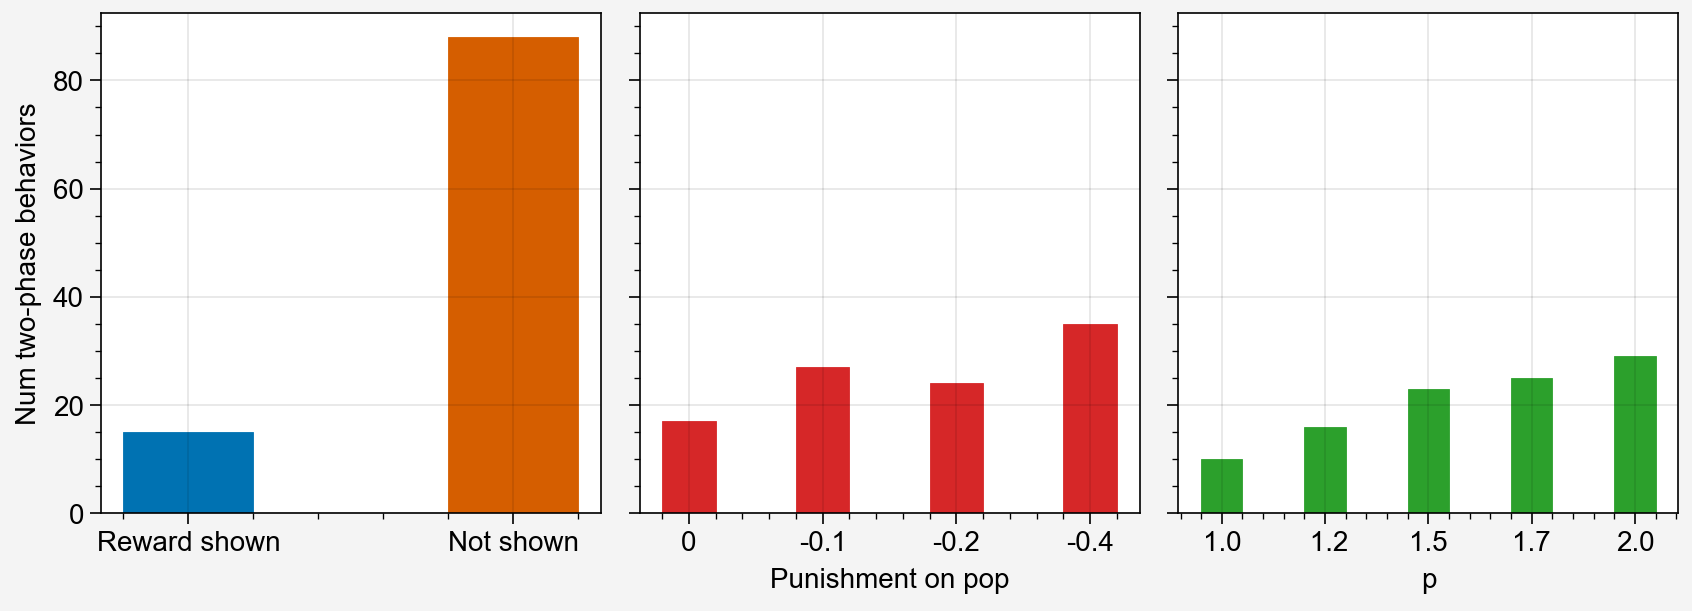

In [50]:
fig, ax = pplt.subplots(ncols=3, sharex=False)
for h in range(2):
    idxs = select_chks_by_dimension(h=h, with_chk=True)
    num_twophase = 0
    for idx in idxs:
        its = res['unpopped_sizes'][idx].mean(axis=1)
        m = res['unpopped_sizes'][idx].mean(axis=1)[-1]
        p = res['pop_rate'][idx]
        twophase = np.any(np.diff(its) > 0.15)
        num_twophase += 1*twophase
    ax[0].bar(h, num_twophase)
for i in range(4):
    idxs = select_chks_by_dimension(i=i, with_chk=True)
    num_twophase = 0
    for idx in idxs:
        its = res['unpopped_sizes'][idx].mean(axis=1)
        m = res['unpopped_sizes'][idx].mean(axis=1)[-1]
        p = res['pop_rate'][idx]
        twophase = np.any(np.diff(its) > 0.15)
        num_twophase += 1*twophase
    ax[1].bar(i, num_twophase, c=rgb_colors[3])
for j in range(5):
    idxs = select_chks_by_dimension(j=j, with_chk=True)
    num_twophase = 0
    for idx in idxs:
        its = res['unpopped_sizes'][idx].mean(axis=1)
        m = res['unpopped_sizes'][idx].mean(axis=1)[-1]
        p = res['pop_rate'][idx]
        twophase = np.any(np.diff(its) > 0.15)
        num_twophase += 1*twophase
    ax[2].bar(j, num_twophase, c=rgb_colors[2])

ax[0].format(xlocator=range(2), xformatter=give_labels, ylabel='Num two-phase behaviors')
ax[1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis)
ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)

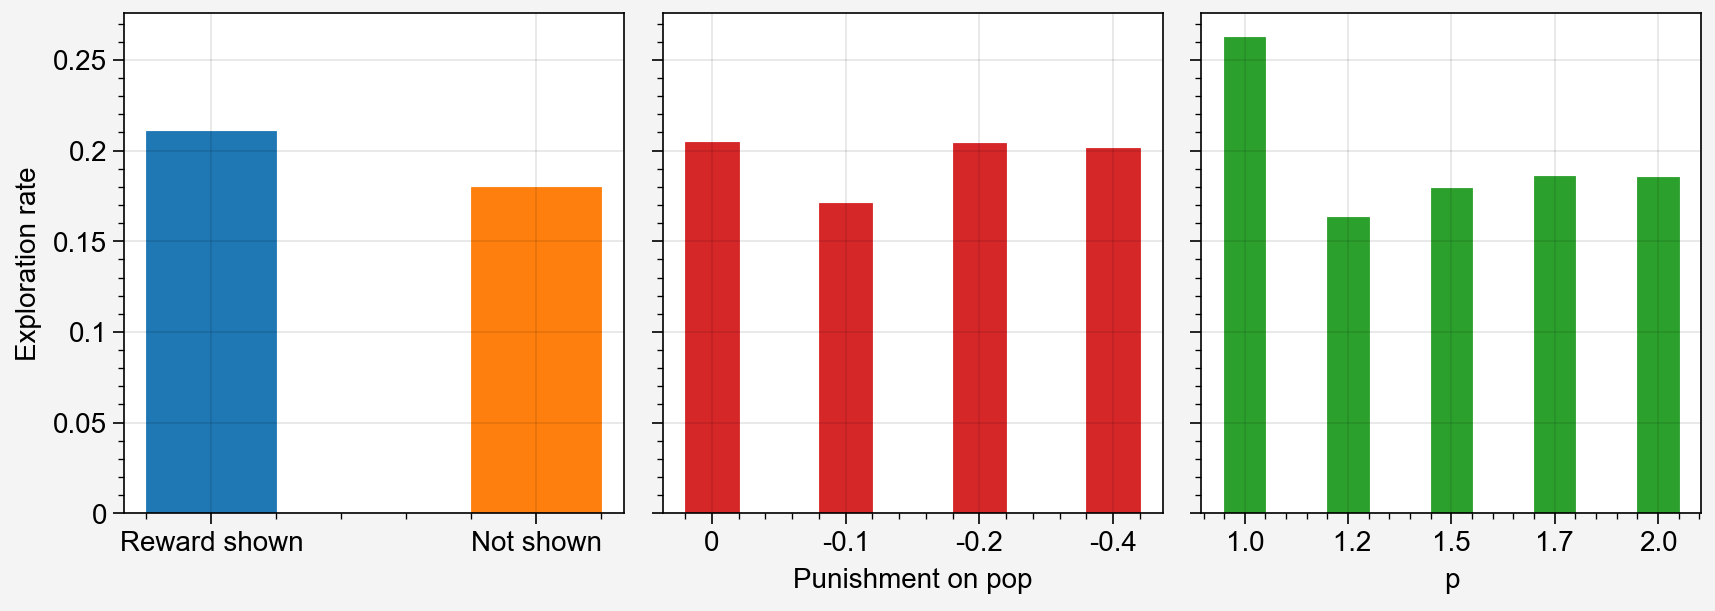

In [57]:
fig, ax = pplt.subplots(ncols=3, sharex=False)
for h in range(2):
    ax[0].bar(h, summary['gradual_exploration'][h].mean(), c=rgb_colors[h])
for i in range(4):
    ax[1].bar(i, summary['gradual_exploration'][:, i].mean(), c=rgb_colors[3])
for j in range(5):
    ax[2].bar(j, summary['gradual_exploration'][:, :, j].mean(), c=rgb_colors[2])

ax[0].format(xlocator=range(2), xformatter=give_labels, ylabel='Exploration rate')
ax[1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis)
ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)

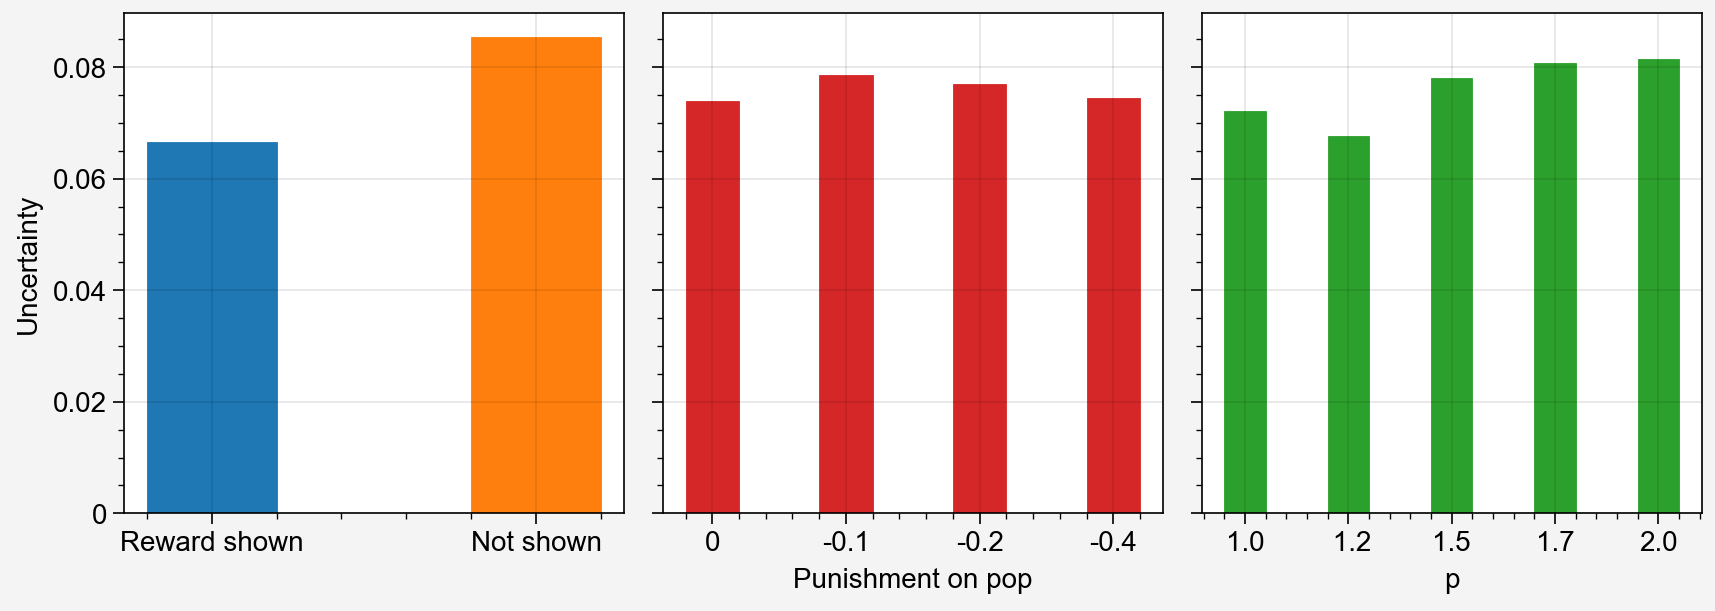

In [78]:
fig, ax = pplt.subplots(ncols=3, sharex=False)
for h in range(2):
    ax[0].bar(h, summary['uncertainty'][h].mean(), c=rgb_colors[h])
for i in range(4):
    ax[1].bar(i, summary['uncertainty'][:, i].mean(), c=rgb_colors[3])
for j in range(5):
    ax[2].bar(j, summary['uncertainty'][:, :, j].mean(), c=rgb_colors[2])

ax[0].format(xlocator=range(2), xformatter=give_labels, ylabel='Uncertainty')
ax[1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis)
ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)

## 1.2 Behavioral Strategy Visualizations

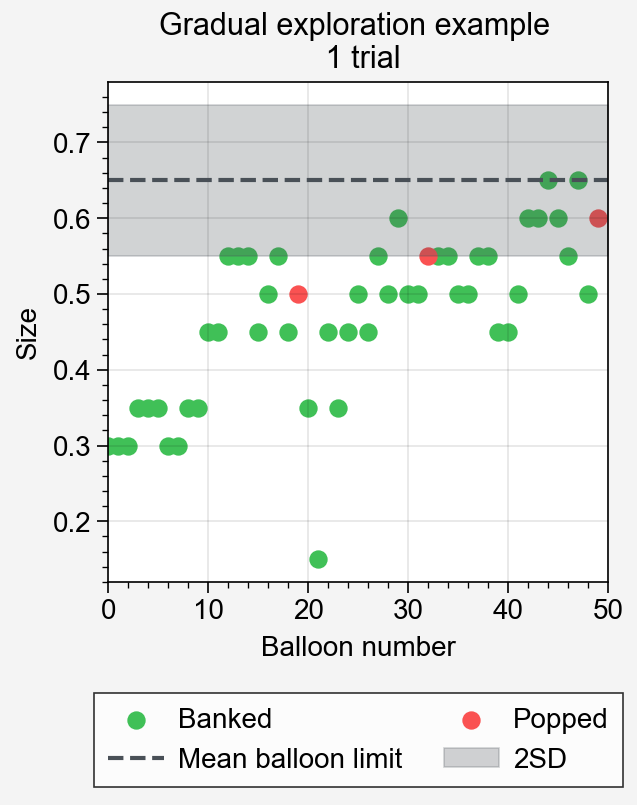

In [69]:
fig, ax = pplt.subplots(ncols=1)
example_idxs = [(1, 0, 3, 2)]
chkidxs = select_chks(example_idxs)
ep = 9
mus = np.arange(0.2, 1.01, 0.05)

idx = chkidxs[0]
sizes = res['unpopped_sizes'][idx][ep]
pops = res['last_sizes'][idx][ep] == 0

x = np.arange(50)

lines = []
lines.append(ax[0].scatter(x[~pops], sizes[~pops], c='green6', label='Banked'))
lines.append(ax[0].scatter(x[pops], sizes[pops], c='red6', label='Popped'))
lines.append(ax[0].plot([0, 50], [mus[ep], mus[ep]], c='gray7', linestyle='--', label='Mean balloon limit'))
lines.append(ax[0].fill_between([0, 50], [mus[ep]-0.1, mus[ep]-0.1], [mus[ep]+0.1, mus[ep]+0.1], label='2SD',
                c='gray7', alpha=0.25))

fig.legend(lines, loc='b', ncols=2)
ax[0].format(xlabel='Balloon number', ylabel='Size', title='Gradual exploration example \n 1 trial')

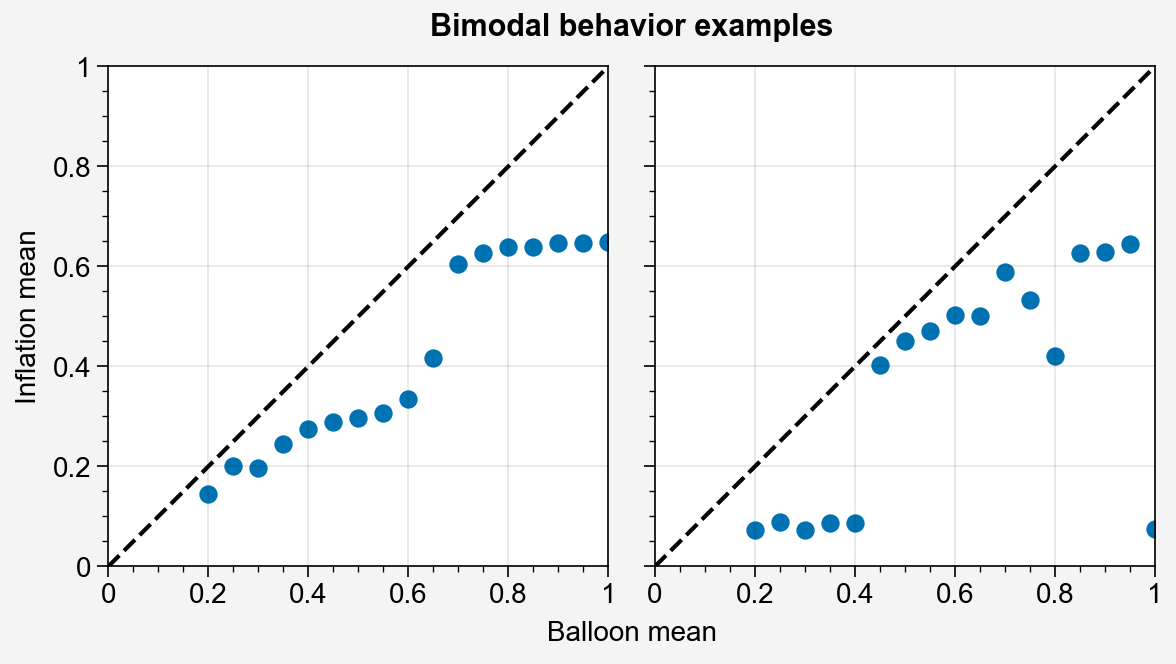

In [142]:
example_idxs = [(1, 1, 4, 1), (1, 1, 4, 2)]
chkidxs = select_chks(example_idxs)
fig, ax = pplt.subplots(ncols=2)
for i, idx in enumerate(chkidxs):
    its = res['unpopped_sizes'][idx].mean(axis=1)
    m = res['unpopped_sizes'][idx].mean(axis=1)[-1]
    p = res['pop_rate'][idx]

    ax[i].scatter(mus, its, label='Mean IT')
    ax[i].plot([0, 1], [0, 1], '--k')
# ax[0].legend(loc='ul', ncols=1)
ax.format(xlabel='Balloon mean', ylabel='Inflation mean',  xlim=[0, 1], ylim=[0, 1],
          suptitle='Bimodal behavior examples')

# 2. Representation Structures

## 2.1 Decision Nodes

Some issues with this currently, looks like things are not being clearly classified as decision nodes, need to go back and work through find_decision_nodes function

In [88]:
_, model, obs_rms, r = select_random_model(seed=0, load_models=True)

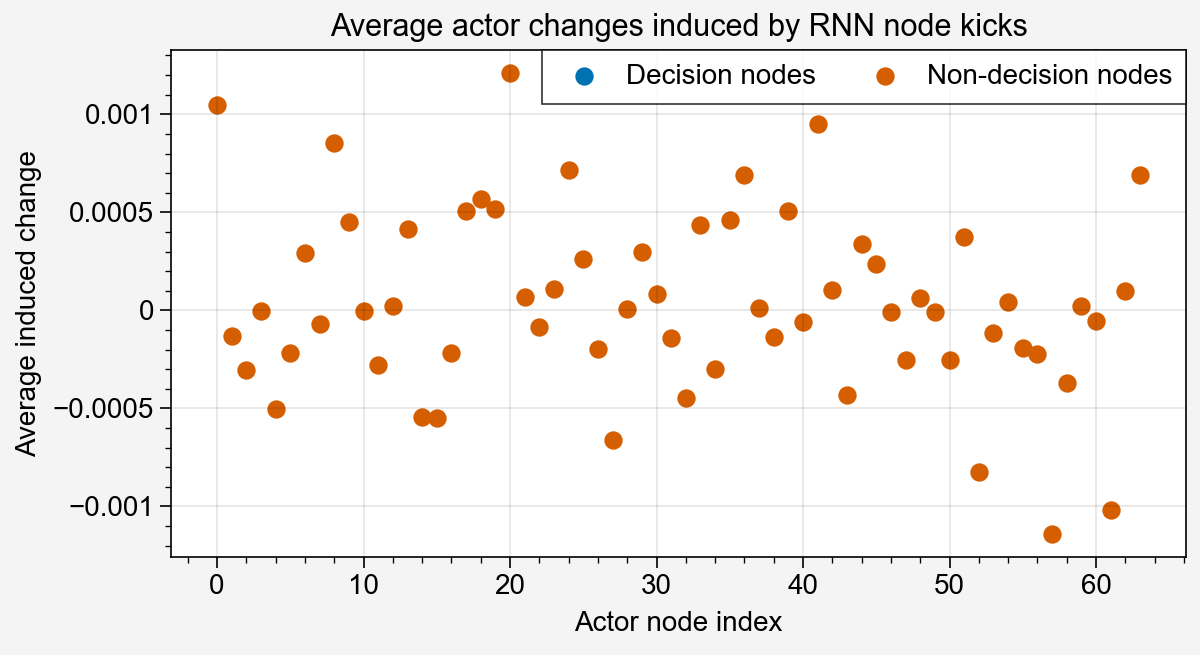

In [90]:
ep = 12
presses = np.argwhere((r['actions'][ep] == 1).reshape(-1)).reshape(-1)
ends = np.array(r['data']['balloon_step'][ep])
end_presses = np.intersect1d(presses, ends)
penult_steps = end_presses - 1
decision_nodes = find_decision_nodes(r, model, ep)
delt_actor0, probs = measure_rnn_influence_multi(r, model, ep, penult_steps,
                                            decision_nodes=decision_nodes,
                                            large_kick=False, ap=True)

fig, ax = pplt.subplots(refaspect=2, figwidth=6)
step_idx = 10
step = penult_steps[step_idx]

actor0 = r['activations']['actor0'][ep][step]
# ax.scatter(actor0)
ax.scatter(delt_actor0[step_idx, 0] / decision_nodes.sum(), label='Decision nodes')
ax.scatter(delt_actor0[step_idx, 1] / (~decision_nodes).sum(), label='Non-decision nodes')
ax.format(xlabel='Actor node index', ylabel='Average induced change',
          title='Average actor changes induced by RNN node kicks')
ax.legend()

## 2.2 Ramping Decision Process

## 2.3 Bimodal RNN

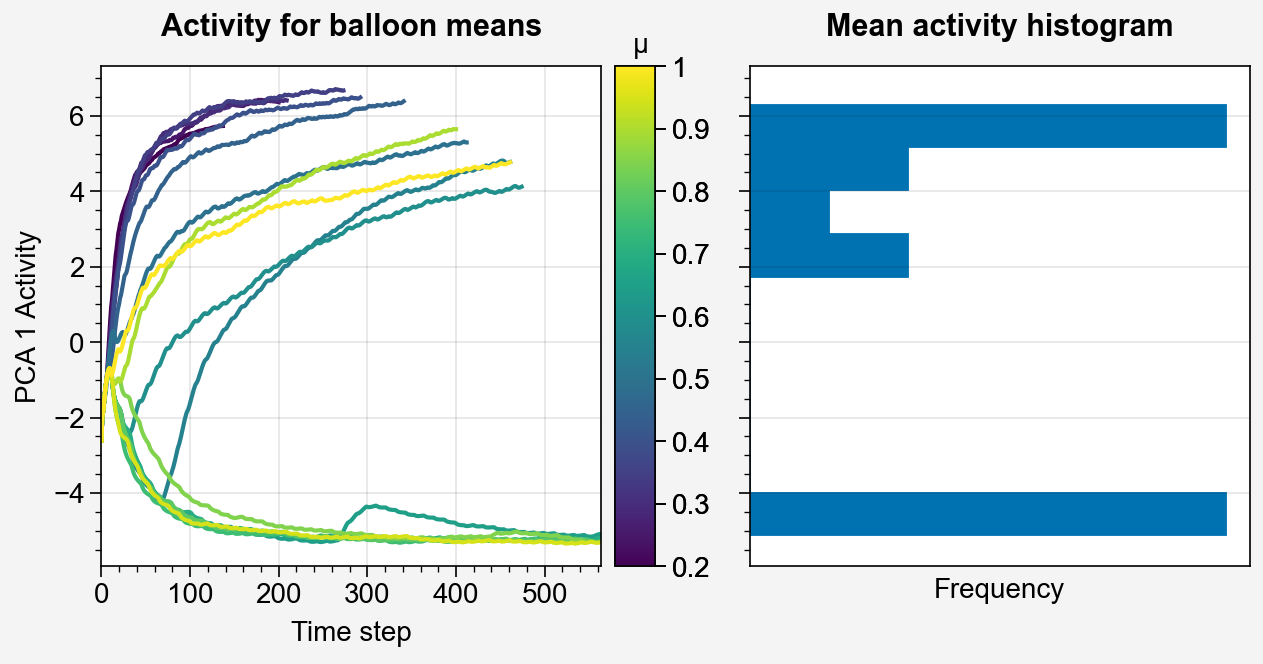

In [160]:
idx = (1, 3, 3, 0)
rnn_hxs = ares['all_rnn_hxs'][idx]
lens = ares['all_ep_lens'][idx]
has_bimodal, ep_rnn, ps, n, ep_mean_rnn = find_bimodal_rnn_pca(rnn_hxs, lens)

n = np.argmin(ps)
fig, ax = pplt.subplots(ncols=2, spanx=False)

bsizes = np.arange(0.2, 1.01, 0.05)
vmin = 0.2
vmax = 1

for j in range(17):
    s = bsizes[j]
    c = get_color_from_colormap(s, vmin, vmax, to_hex=False) 
    pca = ep_rnn[j][:, n]
    ax[0].plot(list(pd.Series(pca).ewm(alpha=0.01).mean()),
            c=c)
cm = create_color_map(0.2, 1,)
ax[0].colorbar(cm)
fig.text(0.5, 0.92, '$\mu$')
ax[1].hist(ep_mean_rnn[:, n], orientation='horizontal')
ax.format(ylabel=f'PCA {n+1} Activity', toplabels=['Activity for balloon means', 
                                         'Mean activity histogram'])
ax[0].format(xlabel='Time step')
ax[1].format(xlabel='Frequency', xlocator=[])

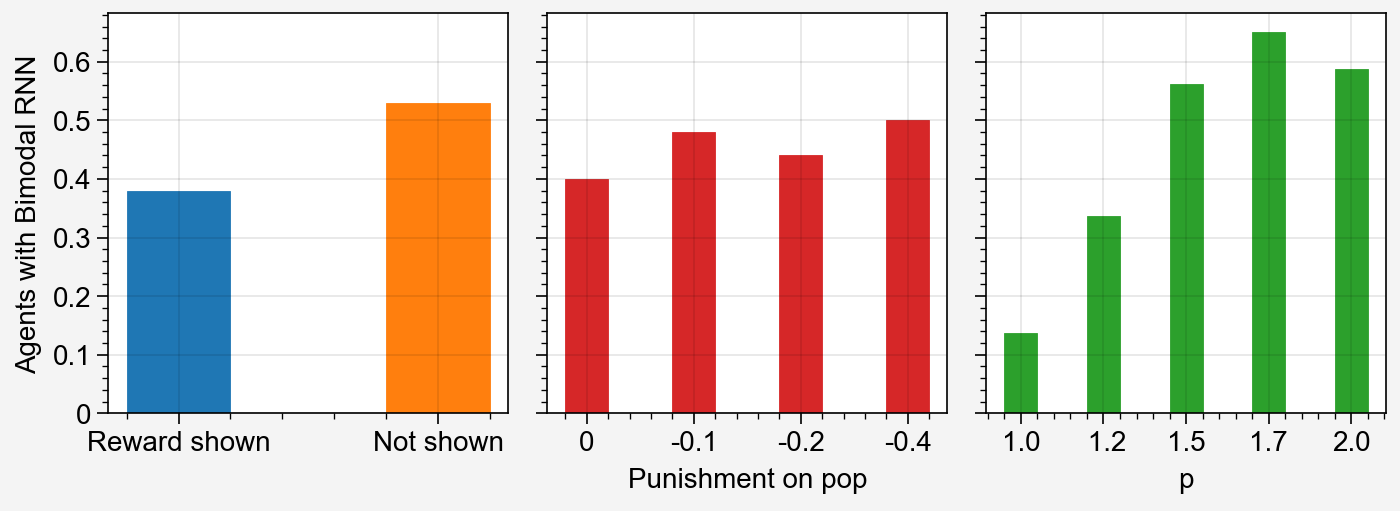

In [506]:
fig, ax = pplt.subplots(ncols=3, sharex=False, figwidth=7)
for h in range(2):
    ax[0].bar(h, summary['bimodal_rnn'][h].mean(), c=rgb_colors[h])
for i in range(4):
    ax[1].bar(i, summary['bimodal_rnn'][:, i].mean(), c=rgb_colors[3])
for j in range(5):
    ax[2].bar(j, summary['bimodal_rnn'][:, :, j].mean(), c=rgb_colors[2])

ax[0].format(xlocator=range(2), xformatter=give_labels, ylabel='Agents with Bimodal RNN')
ax[1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis)
ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)

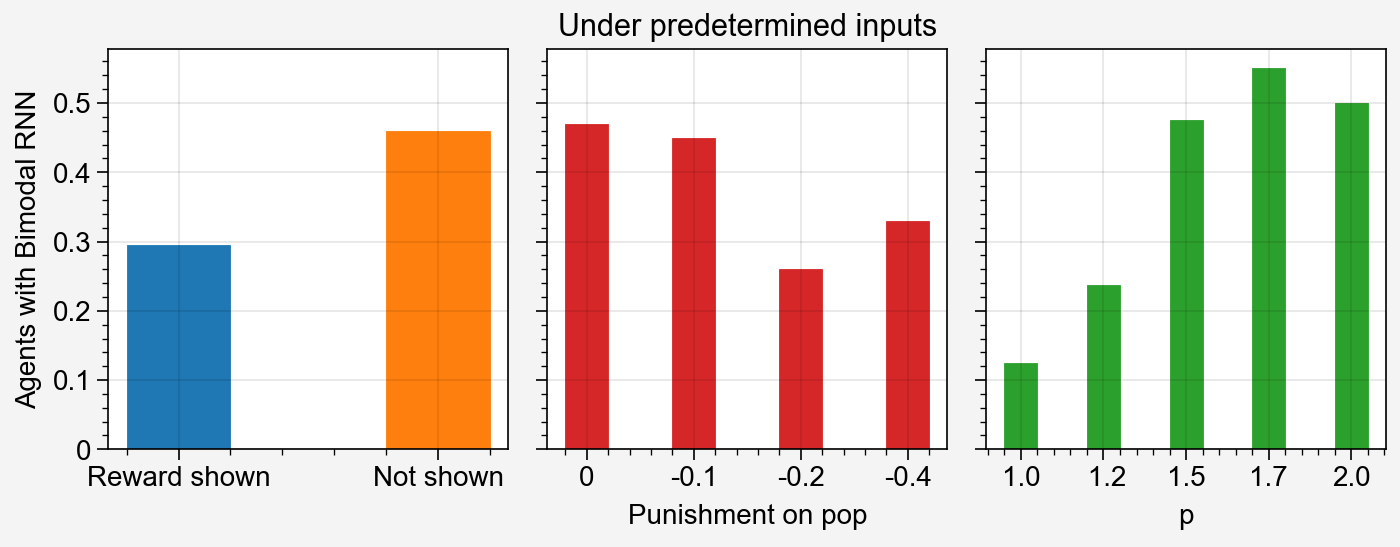

In [509]:
forced10 = pickle.load(open('data/meta_rnn_forced_gradients_10', 'rb'))
fig, ax = pplt.subplots(ncols=3, sharex=False, figwidth=7)
for h in range(2):
    ax[0].bar(h, forced10['bimodal_rnn'][h].mean(), c=rgb_colors[h])
for i in range(4):
    ax[1].bar(i, forced10['bimodal_rnn'][:, i].mean(), c=rgb_colors[3])
for j in range(5):
    ax[2].bar(j, forced10['bimodal_rnn'][:, :, j].mean(), c=rgb_colors[2])

ax[0].format(xlocator=range(2), xformatter=give_labels, ylabel='Agents with Bimodal RNN')
ax[1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis,
             title='Under predetermined inputs')
ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)


## 2.4 Clustering Node activities - slow vs fast clusters

This section introduces the idea of clustering RNN activities, although I think we will likely use clustering across agents throughout the whole paper, rather than doing clustering within an agent, and then across agents which would be too confusing. This sets us up to talk about clustering agent types later.

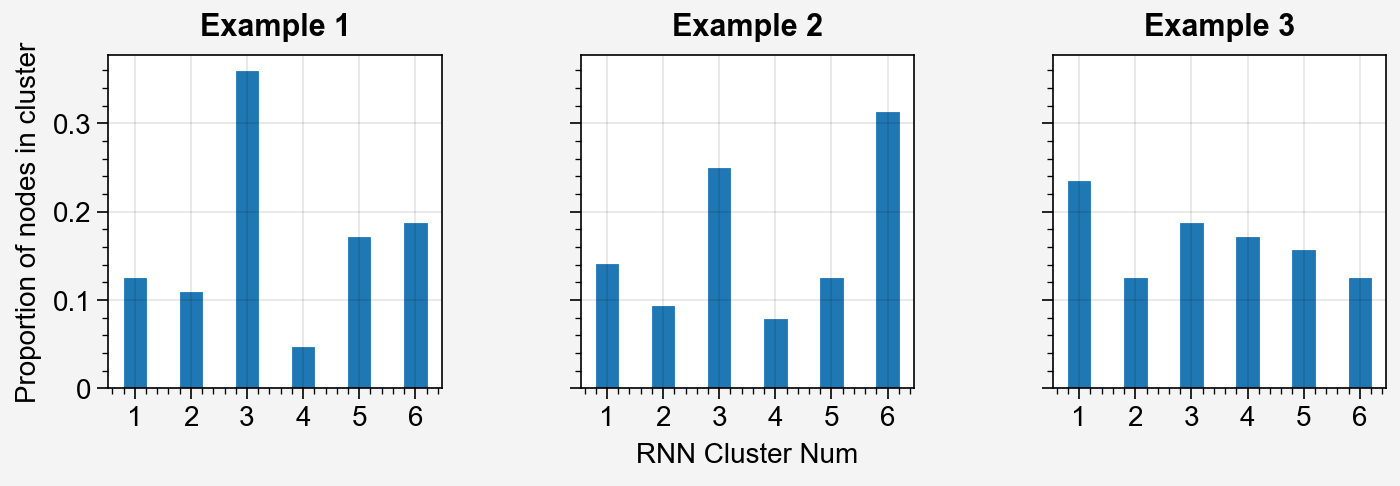

In [24]:
idxs = [(0, 1, 1, 0), (0, 1, 1, 2), (0, 2, 2, 0)]
fig, ax = pplt.subplots(ncols=3, wspace=5, figwidth=7)
for j, idx in enumerate(idxs):
    nodes = np.array(forced_ares['agent_node_meta_labels'][idx])
    for i in range(6):
        ax[j].bar(i, (nodes == i).sum() / 64, c=rgb_colors[0])

ax.format(xlabel='RNN Cluster Num', ylabel='Proportion of nodes in cluster',
          xlocator=range(6), xformatter=[str(i) for i in range(1, 7)],
          toplabels=['Example 1', 'Example 2', 'Example 3'])

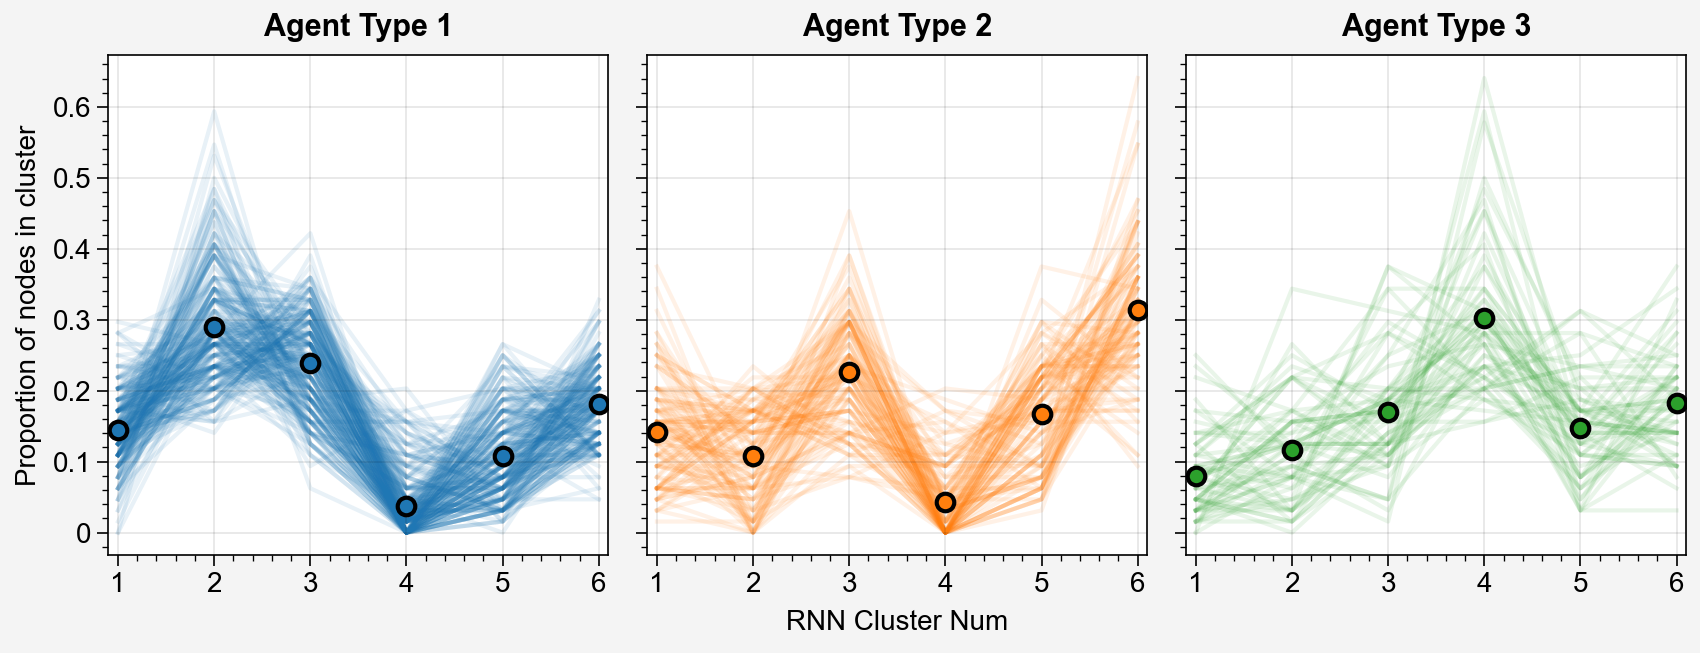

In [ ]:
agent_labels = forced_ares['agent_cluster_type']
kmeans = forced_ares['agent_type_kmeans']
clusters = forced_ares['agent_node_meta_labels']
idxs = select_chks_by_dimension()

k = 3
fig, ax = pplt.subplots(ncols=k)
for i in range(k):
    tgts = np.argwhere(agent_labels == i)
    for tgt in tgts:
        c = np.array(clusters[tuple(tgt)])
        freq = np.array([(c == j).sum() for j in range(6)]) / 64
        ax[i].plot(np.arange(6), freq, c=rgb_colors[i], alpha=0.1, zorder=0)
    ax[i].scatter(np.arange(6), kmeans.cluster_centers_[i], c=rgb_colors[i],
                  edgecolors='black', linewidths=1.5, s=40, zorder=2)

ax.format(xlabel='RNN Cluster Num', ylabel='Proportion of nodes in cluster',
          toplabels=[f'Agent Type {n}' for n in range(1, 4)],
          xlim=[-0.1, 5.1], xlocator=range(6), xformatter=[str(i) for i in range(1, 7)])

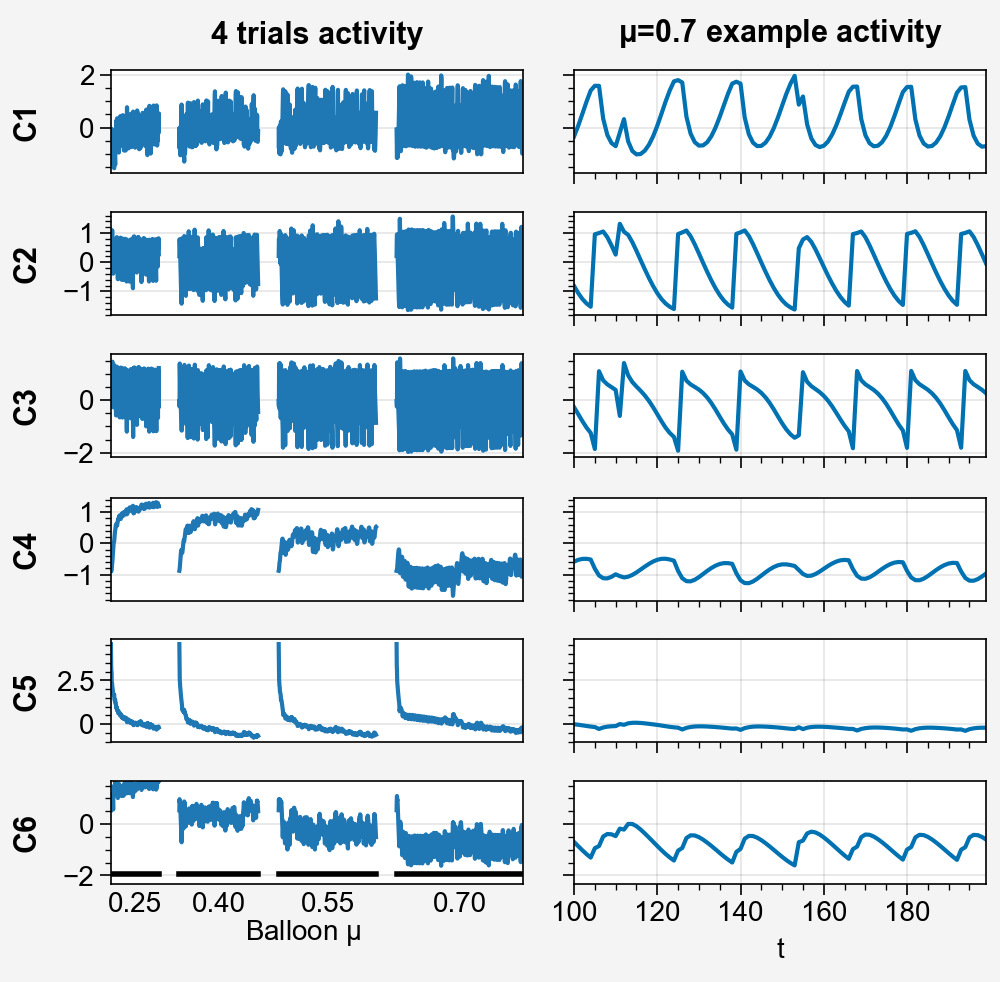

In [202]:
mus = np.arange(0.2, 1.01, 0.05)[np.array([1, 4, 7, 10])]
centers = forced_ares['node_kmeans'].cluster_centers_
lens = [len(o) for o in forced_ares['fixprev_res']['obs']]

fig, ax = pplt.subplots(nrows=len(centers), ncols=2, refaspect=4, figwidth=5,
                        spanx=False)

for i in range(len(centers)):
    xlocations = []
    cur = 0
    for j in range(4):
        nxt = cur + lens[j]
        xlocations.append([cur+j*100, nxt+j*100])
        ax[i, 0].plot(range(cur+j*100, nxt+j*100), centers[i][cur:cur+lens[j]], 
                      c=rgb_colors[0])
        cur = nxt
    ax[i, 1].plot(centers[i][1503:1603])
ax.format(leftlabels=[f'C{i}' for i in range(1, 7)],
          toplabels=['4 trials activity', '$\mu$=0.7 example activity'])
ax[:, 0].format(xlocator=[])
ax[:, 1].format(xlocator=np.arange(0, 100, 20), 
          xformatter=[str(i) for i in np.arange(100, 200, 20)],
          xlabel='t')

low = centers[-5].min()
high = centers[-5].max()
for i, (x1, x2) in enumerate(xlocations):
    ax[-1, 0].plot([x1, x2], [low-0.3, low-0.3], c='black', lw=2)
    ax[-1, 0].text((x1 + x2) / 2, low - 1, f'{mus[i]:.2f}', ha='center', 
                   va='top')
ax[-1, 0].text(np.mean(xlocations)*1.1, low-2, 'Balloon $\mu$', ha='center',
               va='top')
ax[-1, 0].format(ylim=[low-0.7, high+0.1])

### 2.4.1 Cluster Frequencies Defining Agent Types

Using significance we can more easily tell which clusters make for defining features for each agent type:
- Type 1: +2, -5
- Type 2: +6
- Type 3: -1, -3, +4

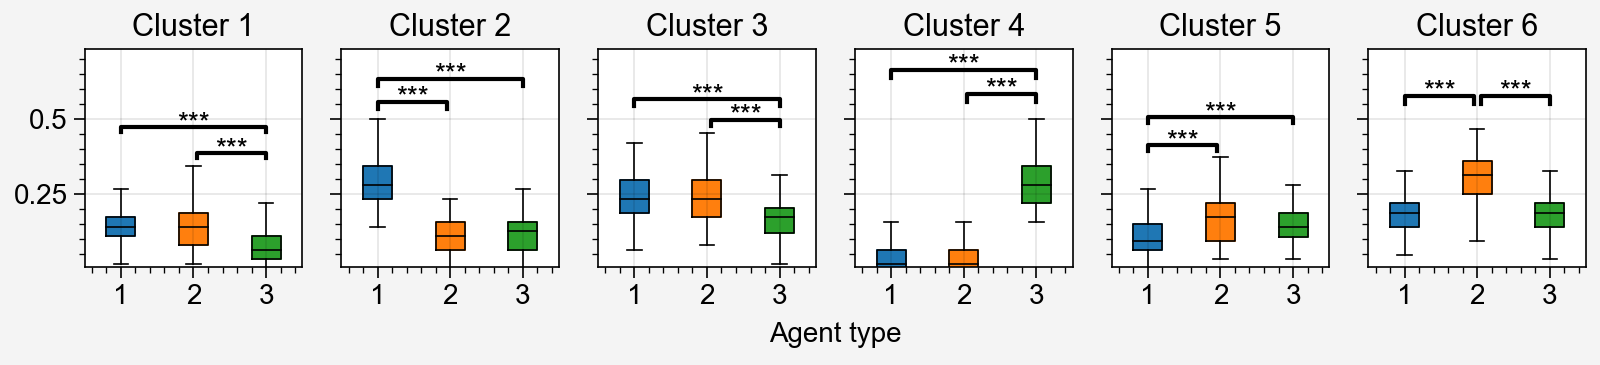

In [ ]:
# Check which cluster frequency relations are significant

agent_labels = forced_ares['agent_cluster_type']
shaped_labels = agent_labels.reshape(shape)
clusters = forced_ares['agent_node_meta_labels']

fig, ax = pplt.subplots(ncols=6, sharey=True, figwidth=8)

cluster_freqs = []
for j in range(3):
    y = []
    tgts = np.argwhere(agent_labels == j)
    for tgt in tgts:
        c = np.array(clusters[tuple(tgt)])
        freq = np.array([(c == j).sum() for j in range(6)]) / 64
        y.append(freq)
    cluster_freqs.append(np.array(y))
    

for i in range(6):
    ys = []
    for j in range(3):
        y = cluster_freqs[j][:, i].copy()
        ys.append(y)
        b = ax[i].boxplot(j, y, fliers=False, widths=0.4)
        color_boxplot(b, rgb_colors[j], ax[i])
    ax[i].format(title=f'Cluster {i+1}')

    bar_dy_ratio = 5 if i in [0, 4] else 3
    lim_dy_ratio = 5
    agent_type_significance_test(ys, ax[i], bar_dy_ratio=bar_dy_ratio,
                                 lim_dy_ratio=lim_dy_ratio)

ax.format(xlabel='Agent type', xlocator=range(3), xformatter=[str(i) for i in range(1, 4)])

## 2.5 Individual node stimulis

Here we also want to discuss fast/slow resetting nodes and see whether they always match to the corresponding clusters as well

**come back to this analysis after doing clustering work which probably forms the backbone of the work**

### 2.5.1 Example stimuli responses

In [205]:
idx = (0, 2, 2, 0)
_, model, obs_rms, r = select_random_model(idx=idx, load_models=True)
responses, stim_sizes = perform_stimuli_experiment(model, obs_rms, give=True, stim_sizes=1)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


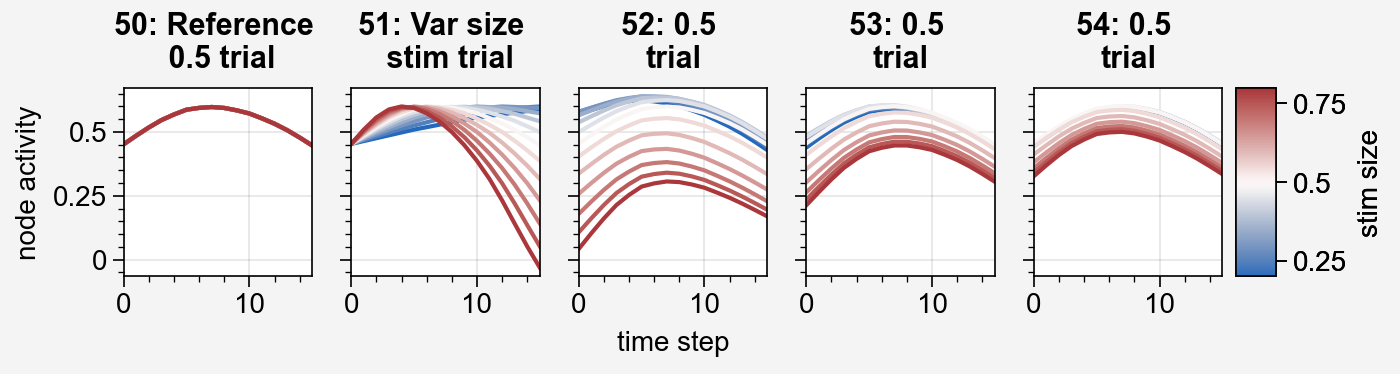

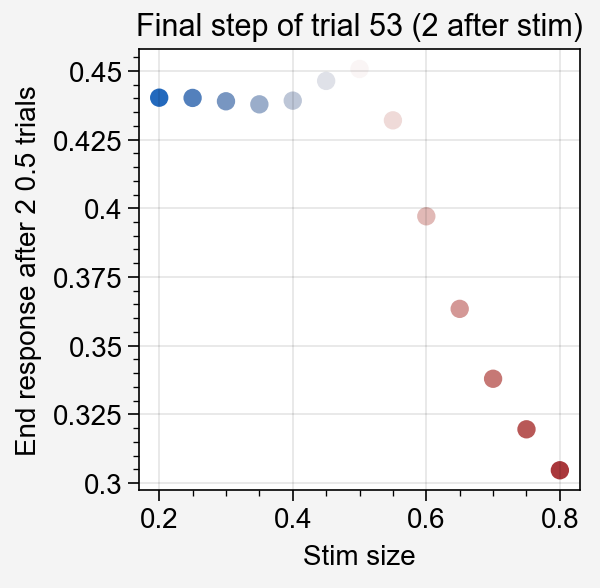

In [208]:
ax1, ax2 = plot_fixed_stimulus_experiment(responses, 24)

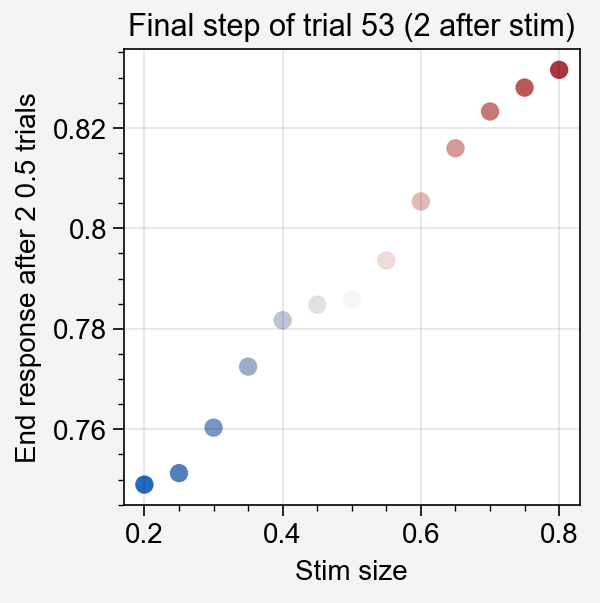

In [229]:
ax = plot_fixed_stimulus_experiment(responses, 44, plots=[2])

# 3. Clustering Agent Types

## 3.1 Effect of training variant on agent type frequency

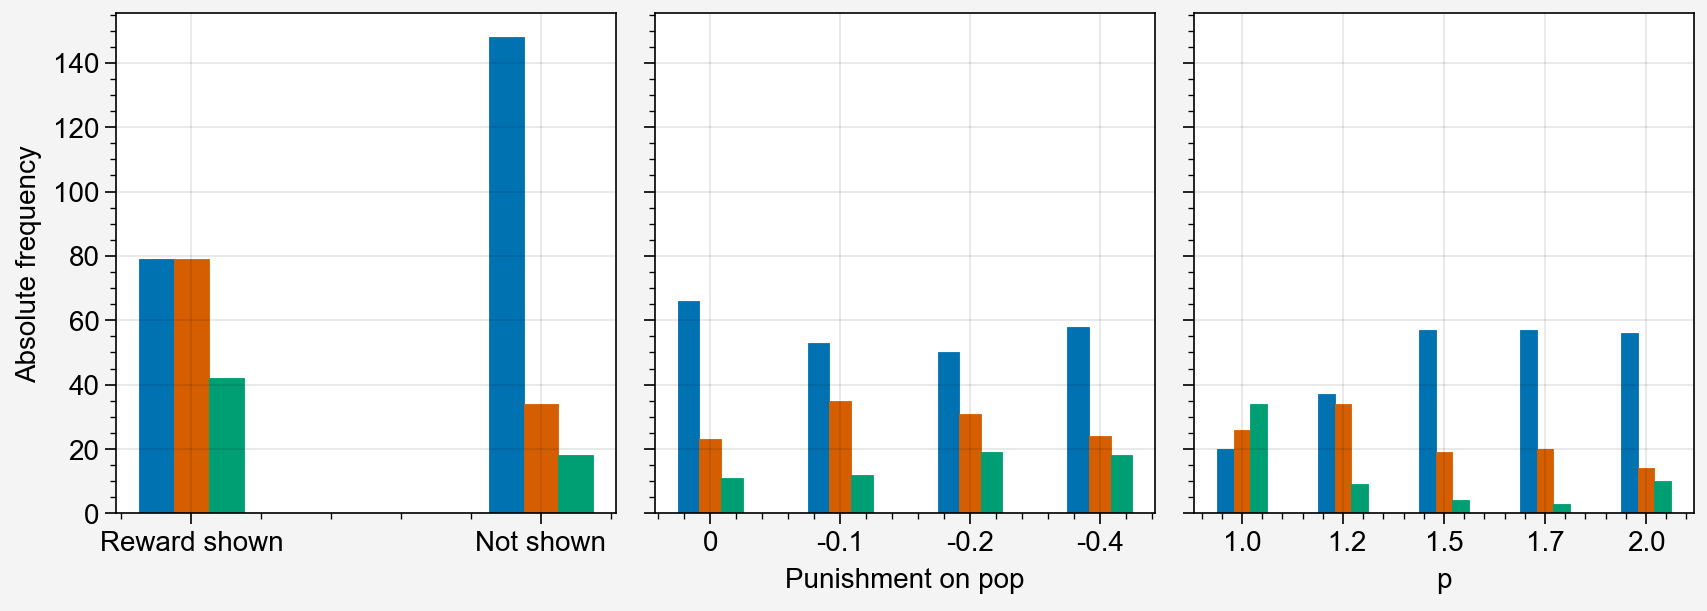

In [259]:
fig, ax = pplt.subplots(ncols=3, sharex=False)
shaped_labels = agent_labels.reshape(shape)
label_counts = []
for h in range(2):
    idxs = select_chks_by_dimension(h=h, i=range(4), with_chk=False)
    l = np.array([shaped_labels[l] for l in idxs])
    l = [(l == i).sum() for i in range(k)]
    label_counts.append(l)
ax[0].bar(np.arange(2), label_counts, width=0.3)

label_counts = []
for i in range(4):
    idxs = select_chks_by_dimension(i=i, with_chk=False)
    l = np.array([shaped_labels[l] for l in idxs])
    l = [(l == i).sum() for i in range(k)]
    label_counts.append(l)
ax[1].bar(np.arange(4), label_counts, width=0.5)
    
label_counts = []
for j in range(5):
    idxs = select_chks_by_dimension(j=j, i=range(4), with_chk=False)
    l = np.array([shaped_labels[l] for l in idxs])
    l = [(l == i).sum() for i in range(k)]
    label_counts.append(l)
ax[2].bar(np.arange(5), label_counts, width=0.5)

    
ax[0].format(xlocator=range(2), xformatter=give_labels, ylabel='Absolute frequency')
ax[1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis)
ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)


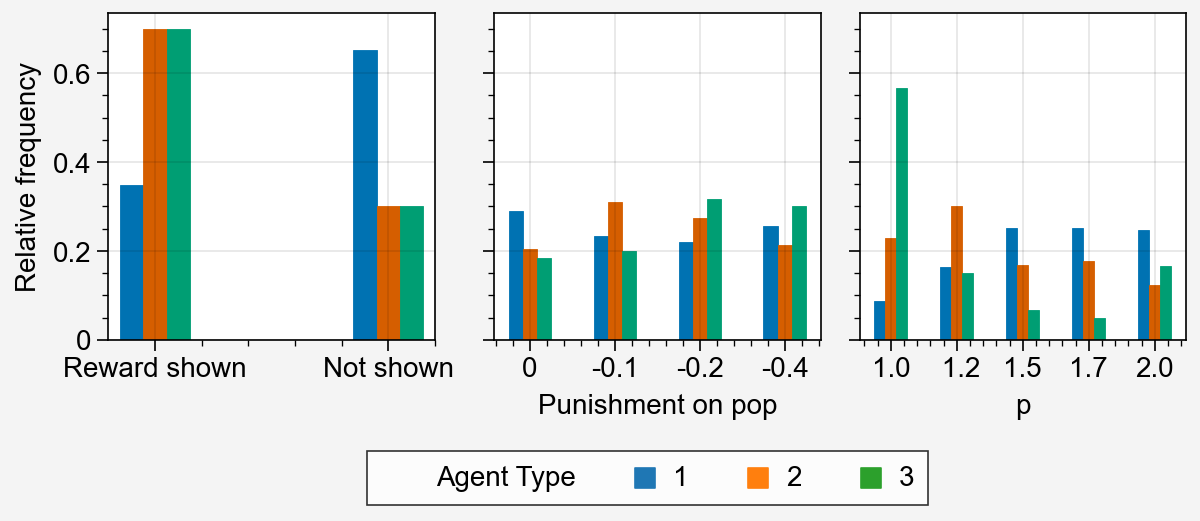

In [423]:
fig, ax = pplt.subplots(ncols=3, sharex=False, figwidth=6)
shaped_labels = agent_labels.reshape(shape)
total_counts = np.array([(shaped_labels == i).sum() for i in range(3)])
label_counts = []
for h in range(2):
    idxs = select_chks_by_dimension(h=h, i=range(4), with_chk=False)
    l = np.array([shaped_labels[l] for l in idxs])
    l = np.array([(l == i).sum() for i in range(k)])
    label_counts.append(l / total_counts)
ax[0].bar(np.arange(2), label_counts, width=0.3)

label_counts = []
for i in range(4):
    idxs = select_chks_by_dimension(i=i, with_chk=False)
    l = np.array([shaped_labels[l] for l in idxs])
    l = np.array([(l == i).sum() for i in range(k)])
    label_counts.append(l / total_counts)
ax[1].bar(np.arange(4), label_counts, width=0.5)
    
label_counts = []
for j in range(5):
    idxs = select_chks_by_dimension(j=j, i=range(4), with_chk=False)
    l = np.array([shaped_labels[l] for l in idxs])
    l = np.array([(l == i).sum() for i in range(k)])
    label_counts.append(l / total_counts)
ax[2].bar(np.arange(5), label_counts, width=0.5)

    
ax[0].format(xlocator=range(2), xformatter=give_labels, ylabel='Relative frequency')
ax[1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis)
ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)


# Add legends
lines = []
lines.append(ax[0].scatter(-2, 0, s=0, label='Agent Type'))
for i in range(1, 4):
    lines.append(
        ax[0].scatter(-2, 0, s=50, marker='s', c=rgb_colors[i-1], label=f'{i}'))
ax[0].format(xlim=[-0.2, 1.2])
fig.legend(lines, loc='b', ncols=4, handlelength=2, handletextpad=0)

## 3.2 Core behavioral differences between agent types

Overall Behavioral Notes
- Agent Type 1: More significantly develops from not being shown reward information, and marked difference for applying bimodal IT strategies
- Agent Type 3: Most notably develops from what seems like a combination of lower p and higher punishment, leading to agents that take longer to train and also develop more gradual exploration tendencies
- Agent Type 2: Develops somewhat evenly across training conditions, and seems to have a medium between the two other agent types

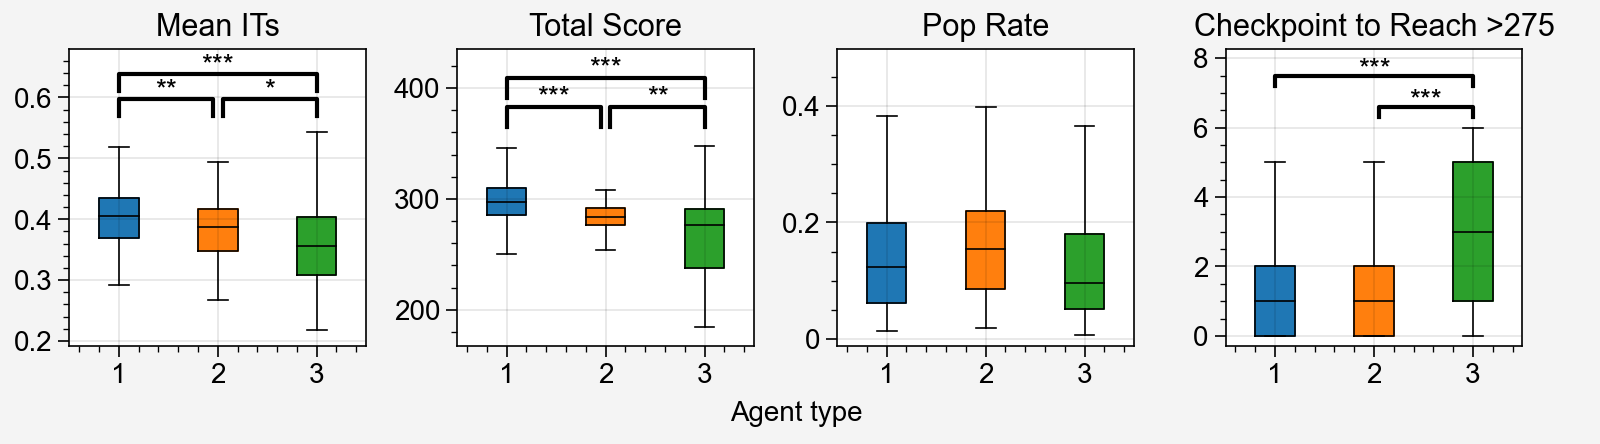

In [456]:
fig, ax = pplt.subplots(ncols=4, sharey=False, figwidth=8)

agent_labels = forced_ares['agent_cluster_type']
shaped_labels = agent_labels.reshape(shape)

plot_keys = ['mean_its', 'total_score', 'pop_rate', 'first_chks']
plot_labels = ['Mean ITs', 'Total Score', 'Pop Rate', 'Checkpoint to Reach >275']
for i in range(4):
    ys = []
    for j in range(3):
        y = summary[plot_keys[i]][shaped_labels == j]
        ys.append(y)
        b = ax[i].boxplot(j, y, fliers=False, widths=0.4)
        color_boxplot(b, rgb_colors[j], ax[i])
    ax[i].format(title=plot_labels[i])

    bar_dy_ratio = 3 if i == 3 else None
    lim_dy_ratio = 4.5 if i == 3 else None
    agent_type_significance_test(ys, ax[i], bar_dy_ratio=bar_dy_ratio,
                                 lim_dy_ratio=lim_dy_ratio)

ax.format(xlabel='Agent type', xlocator=range(3), xformatter=[str(i) for i in range(1, 4)])

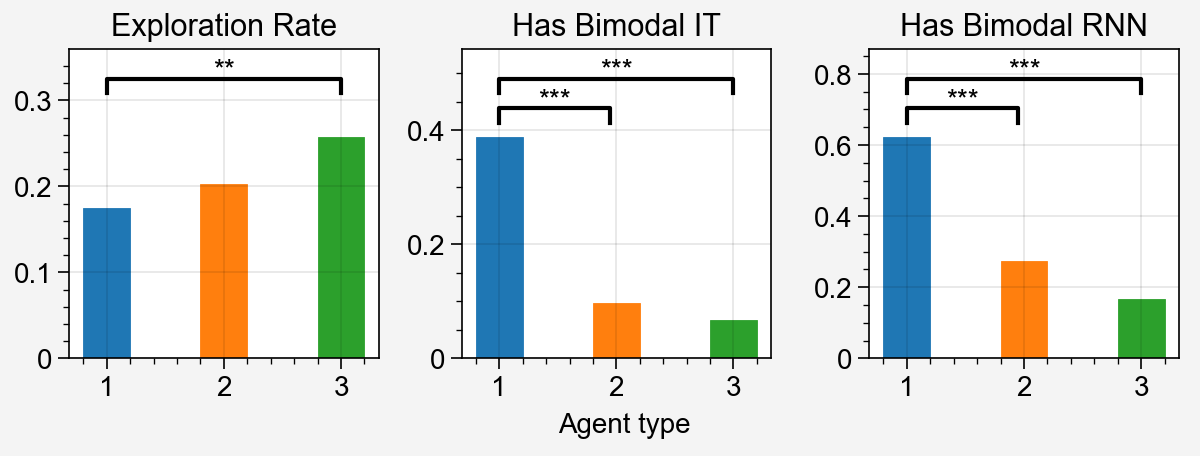

In [394]:
fig, ax = pplt.subplots(ncols=3, sharey=False, figwidth=6)

agent_labels = forced_ares['agent_cluster_type']
shaped_labels = agent_labels.reshape(shape)

plot_keys = ['gradual_exploration', 'bimodal_its', 'bimodal_rnn']
plot_labels = ['Exploration Rate', 'Has Bimodal IT', 'Has Bimodal RNN']
for i in range(3):
    ys = []
    for j in range(3):
        y = summary[plot_keys[i]][shaped_labels == j]
        ys.append(y)
        ax[i].bar(j, np.mean(y), c=rgb_colors[j])
    ax[i].format(title=plot_labels[i])
    agent_type_significance_test(ys, ax[i], boxplot=False)

ax.format(xlabel='Agent type', xlocator=range(3), xformatter=[str(i) for i in range(1, 4)])

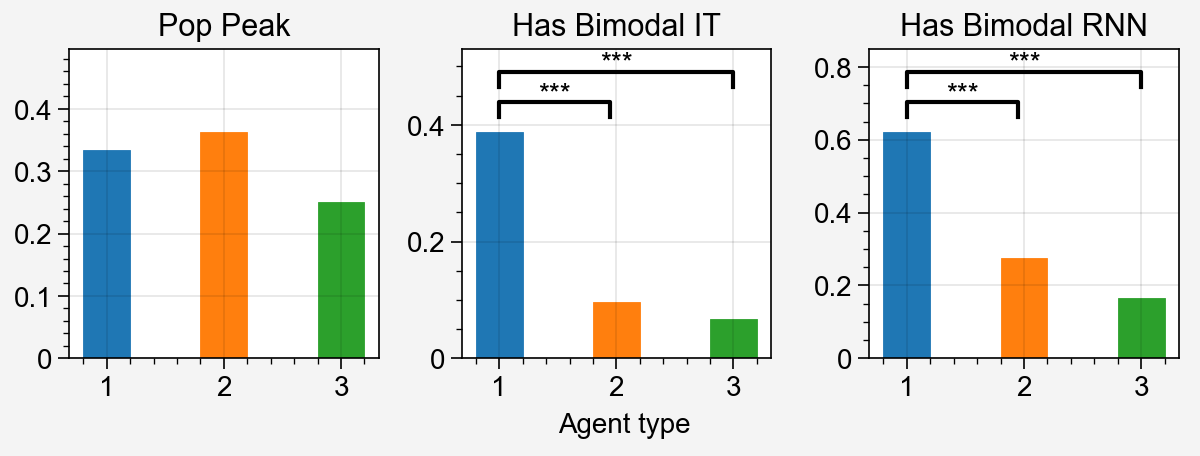

In [27]:
fig, ax = pplt.subplots(ncols=3, sharey=False, figwidth=6)

agent_labels = forced_ares['agent_cluster_type']
shaped_labels = agent_labels.reshape(shape)

plot_keys = ['pop_peaked', 'bimodal_its', 'bimodal_rnn']
plot_labels = ['Pop Peak', 'Has Bimodal IT', 'Has Bimodal RNN']
for i in range(3):
    ys = []
    for j in range(3):
        y = summary[plot_keys[i]][shaped_labels == j]
        ys.append(y)
        ax[i].bar(j, np.mean(y), c=rgb_colors[j])
    ax[i].format(title=plot_labels[i])
    agent_type_significance_test(ys, ax[i], boxplot=False)

ax.format(xlabel='Agent type', xlocator=range(3), xformatter=[str(i) for i in range(1, 4)])

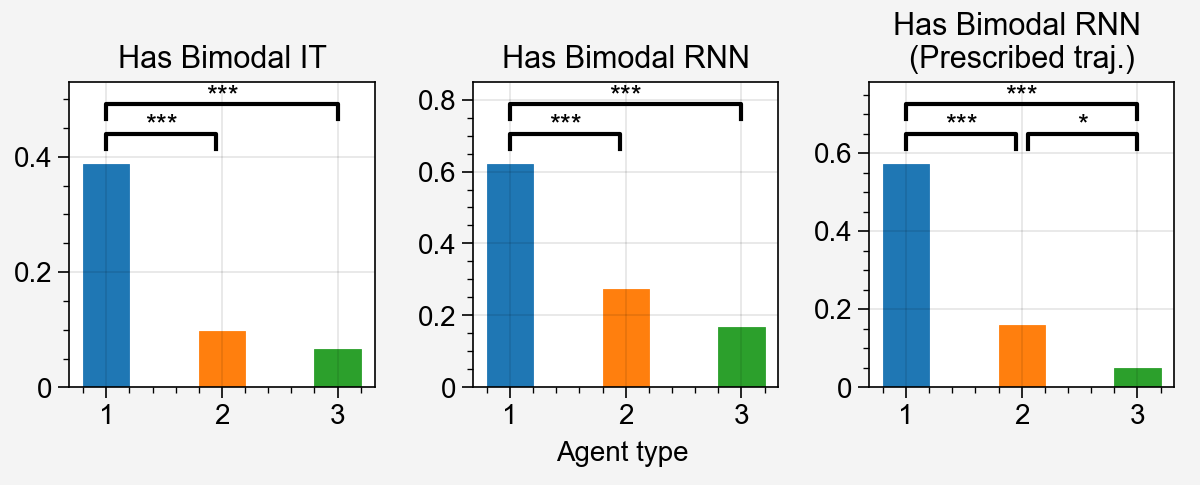

In [166]:
forced10 = pickle.load(open('data/meta_rnn_forced_gradients_10', 'rb'))
fig, ax = pplt.subplots(ncols=3, sharey=False, figwidth=6)

agent_labels = forced_ares['agent_cluster_type']
shaped_labels = agent_labels.reshape(shape)

plot_keys = ['bimodal_its', 'bimodal_rnn', 'bimodal_rnn_forced']
plot_labels = ['Has Bimodal IT', 'Has Bimodal RNN', 'Has Bimodal RNN \n(Prescribed traj.)']
for i in range(3):
    ys = []
    for j in range(3):
        if plot_keys[i] == 'bimodal_rnn_forced':
            y = forced10['bimodal_rnn'][shaped_labels == j]
        else:
            y = summary[plot_keys[i]][shaped_labels == j]
        ys.append(y)
        ax[i].bar(j, np.mean(y), c=rgb_colors[j])
    ax[i].format(title=plot_labels[i])
    agent_type_significance_test(ys, ax[i], boxplot=False)

ax.format(xlabel='Agent type', xlocator=range(3), xformatter=[str(i) for i in range(1, 4)])

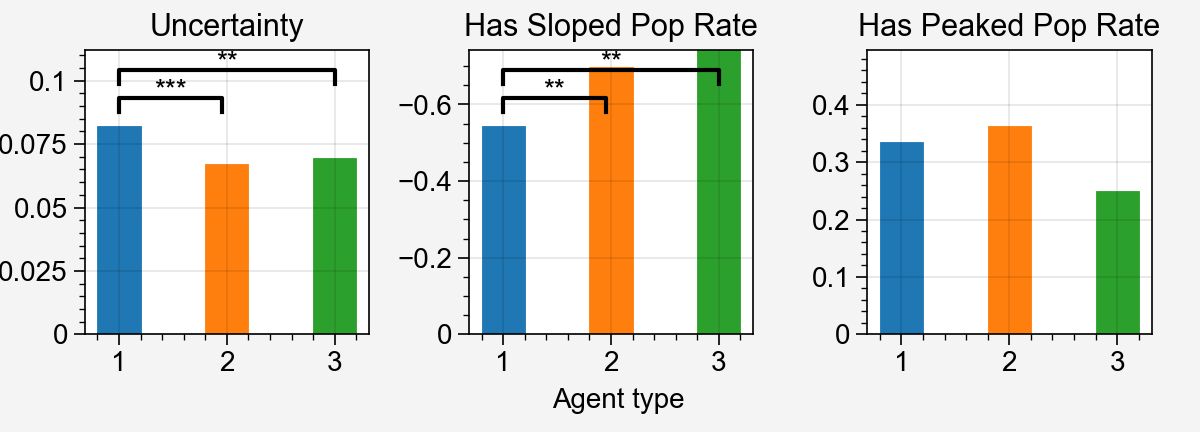

In [426]:
fig, ax = pplt.subplots(ncols=3, sharey=False, figwidth=6)

agent_labels = forced_ares['agent_cluster_type']
shaped_labels = agent_labels.reshape(shape)

plot_keys = ['uncertainty', 'pop_sloped', 'pop_peaked']
plot_labels = ['Uncertainty', 'Has Sloped Pop Rate', 'Has Peaked Pop Rate']
all_ys = []
for i in range(3):
    ys = []
    for j in range(3):
        y = summary[plot_keys[i]][shaped_labels == j]
        ys.append(y)
        ax[i].bar(j, np.mean(y), c=rgb_colors[j])
    ax[i].format(title=plot_labels[i])
    agent_type_significance_test(ys, ax[i], boxplot=False)
    all_ys.append(ys)

ax.format(xlabel='Agent type', xlocator=range(3), xformatter=[str(i) for i in range(1, 4)])

## 3.3 Internal representation differences between agent types

### 3.3.1 Individual Nodes

Some marked difference between agents in their node composition types as well, in particular with left and right sensitivity
- Type 1 Agents prefer right sensitivity
- Type 2 Agents prefer left sensitivity
- Type 3 Agents use a combination of both

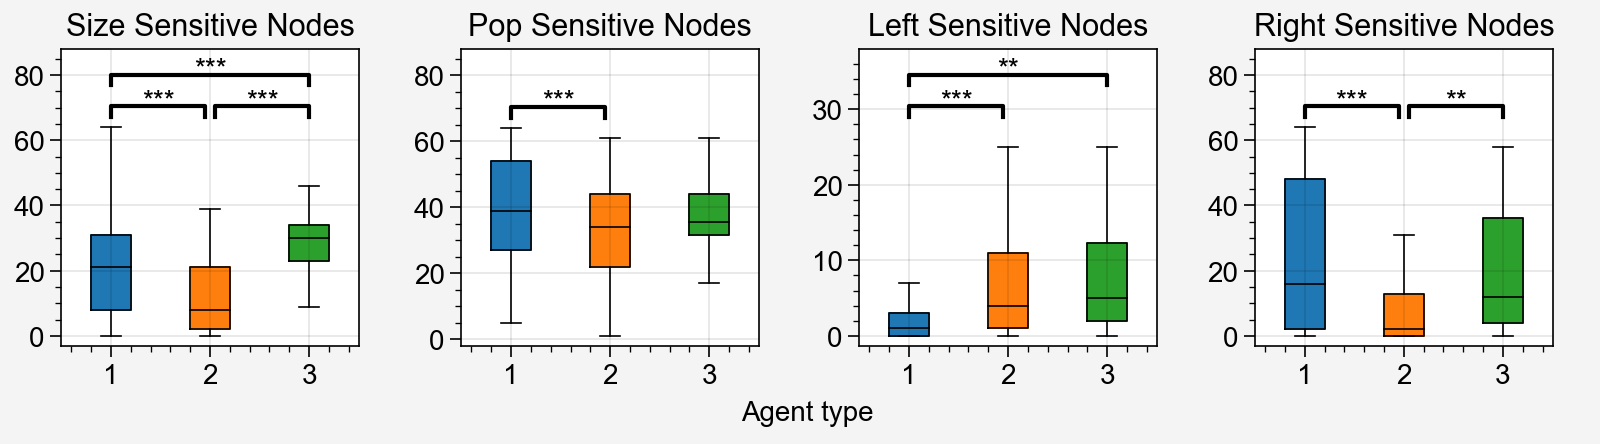

In [463]:
fig, ax = pplt.subplots(ncols=4, sharey=False, figwidth=8)

agent_labels = forced_ares['agent_cluster_type']
shaped_labels = agent_labels.reshape(shape)

plot_keys = ['slow_size_recov', 'slow_pop_recov', 'left_sensitive', 'right_sensitive']
plot_labels = ['Size Sensitive Nodes', 'Pop Sensitive Nodes', 'Left Sensitive Nodes', 'Right Sensitive Nodes']
for i in range(4):
    ys = []
    nodes = summary[plot_keys[i]].sum(axis=4)
    for j in range(3):
        y = nodes[shaped_labels == j]
        ys.append(y)
        b = ax[i].boxplot(j, y, fliers=False, widths=0.4)
        color_boxplot(b, rgb_colors[j], ax[i])
    ax[i].format(title=plot_labels[i])
    agent_type_significance_test(ys, ax[i], boxplot=True, bar_dy_ratio=3, 
                                 lim_dy_ratio=4.5)

ax.format(xlabel='Agent type', xlocator=range(3), xformatter=[str(i) for i in range(1, 4)])

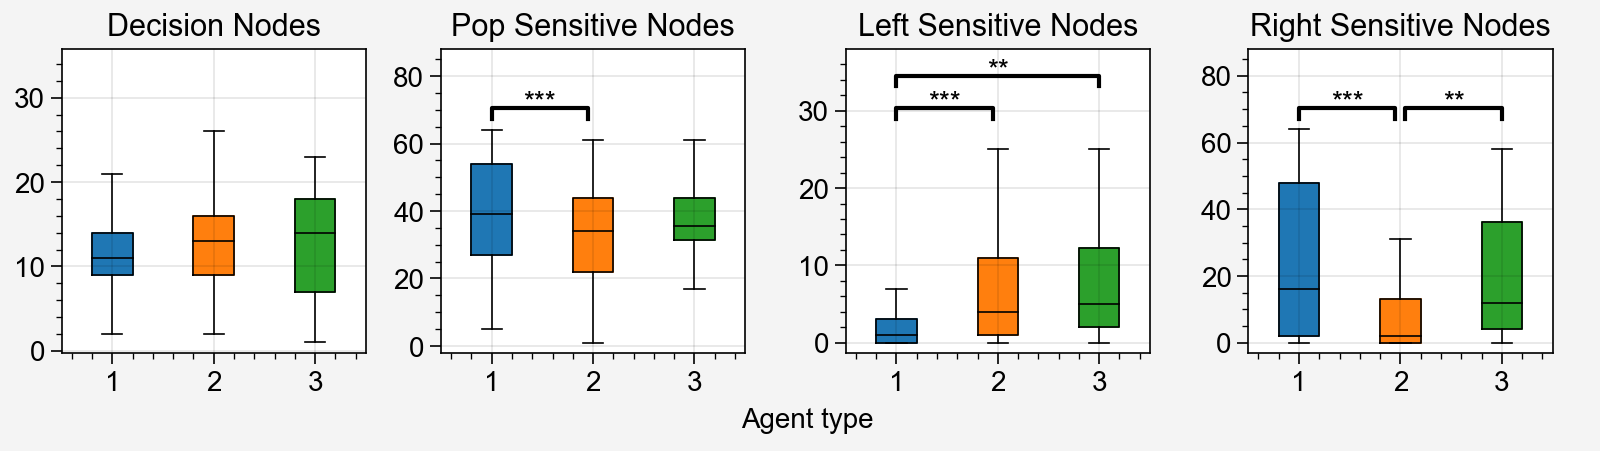

In [7]:
fig, ax = pplt.subplots(ncols=4, sharey=False, figwidth=8)

agent_labels = forced_ares['agent_cluster_type']
shaped_labels = agent_labels.reshape(shape)

plot_keys = ['decision_nodes', 'slow_pop_recov', 'left_sensitive', 'right_sensitive']
plot_labels = ['Decision Nodes', 'Pop Sensitive Nodes', 'Left Sensitive Nodes', 'Right Sensitive Nodes']
for i in range(4):
    ys = []
    nodes = summary[plot_keys[i]].sum(axis=4)
    for j in range(3):
        y = nodes[shaped_labels == j]
        ys.append(y)
        b = ax[i].boxplot(j, y, fliers=False, widths=0.4)
        color_boxplot(b, rgb_colors[j], ax[i])
    ax[i].format(title=plot_labels[i])
    agent_type_significance_test(ys, ax[i], boxplot=True, bar_dy_ratio=3, 
                                 lim_dy_ratio=4.5)

ax.format(xlabel='Agent type', xlocator=range(3), xformatter=[str(i) for i in range(1, 4)])

### 3.3.2 Cluster Node Compositions

Notably, clusters 1-3 are "fast" clusters, but Cluster 2 contains nodes that have long-term responses to surprise size and pops

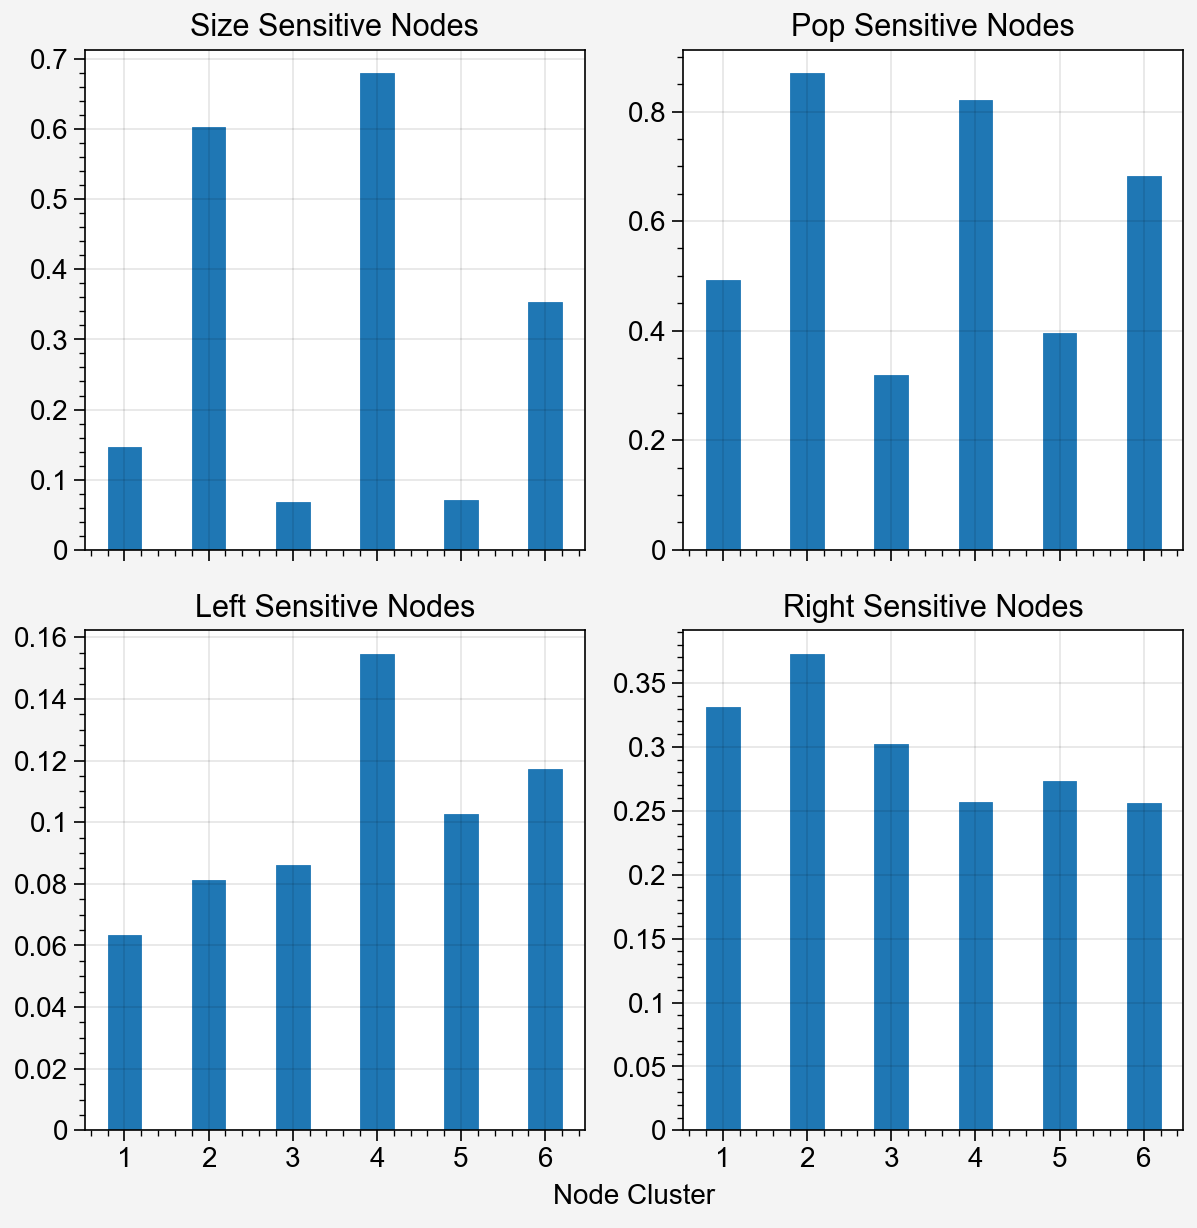

In [ ]:
fig, ax = pplt.subplots(nrows=2, ncols=2, sharey=False)

node_labels = forced_ares['agent_node_meta_labels']
shaped_labels = np.zeros(shape + (64,), dtype='int')
idxs = select_chks_by_dimension()
for idx in idxs:
    shaped_labels[idx] = node_labels[idx]

plot_keys = ['slow_size_recov', 'slow_pop_recov', 'left_sensitive', 'right_sensitive']
plot_labels = ['Size Sensitive Nodes', 'Pop Sensitive Nodes', 'Left Sensitive Nodes', 'Right Sensitive Nodes']
for i in range(4):
    ys = []
    nodes = summary[plot_keys[i]]
    for j in range(6):
        y = nodes[shaped_labels == j]
        ys.append(y)
        ax[i].bar(j, np.mean(y), c=rgb_colors[0])
        # color_boxplot(b, rgb_colors[0], ax[i])
    ax[i].format(title=plot_labels[i])
    # agent_type_significance_test(ys, ax[i], boxplot=True, bar_dy_ratio=3, 
    #                              lim_dy_ratio=4.5)

ax.format(xlabel='Node Cluster', xlocator=range(6), xformatter=[str(i) for i in range(1, 7)])


# 4. Human Data Comparisons


## 4.1 Human tuned performance measures

Only keeping balloon sizes of 0.25, 0.45, 0.7 to somewhat mimic balloon sizes used to compute performance measures in humans. Calibrated based on overall pop rates for different episodes as well as balloon size separations in humans.

Important to note that the exact strategies agents are optimized for will be different than humans due to the spread of balloon sizes seen during training phase. 

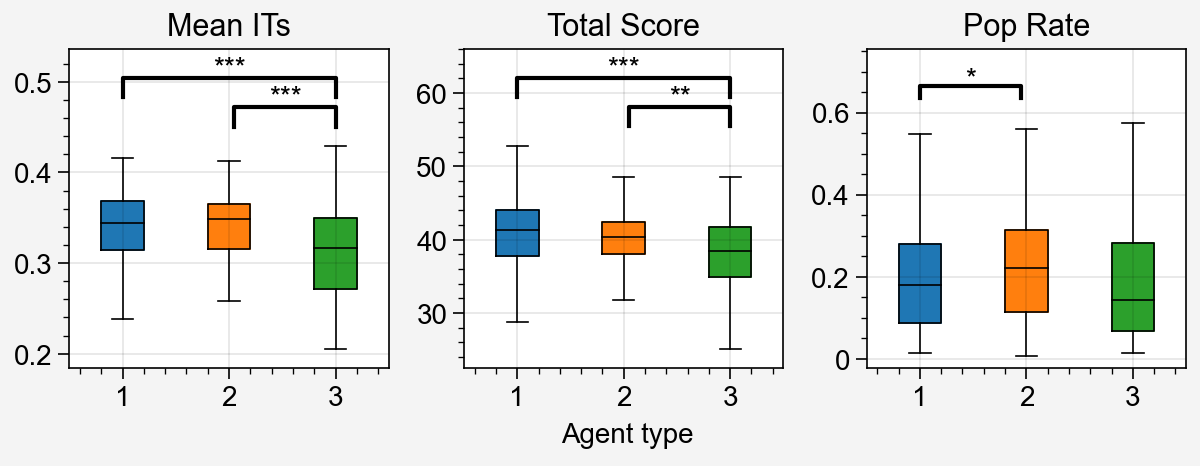

In [3]:
agent_labels = forced_ares['agent_cluster_type']
shaped_labels = agent_labels.reshape(shape)

fig, ax = pplt.subplots(ncols=3, sharey=False, figwidth=6)
plot_keys = ['human_mean_its', 'human_total_score', 'human_pop_rate']
plot_labels = ['Mean ITs', 'Total Score', 'Pop Rate']
for i in range(3):
    ys = []
    for j in range(3):
        y = summary[plot_keys[i]][shaped_labels == j]
        ys.append(y)
        b = ax[i].boxplot(j, y, fliers=False, widths=0.4)
        color_boxplot(b, rgb_colors[j], ax[i])
    ax[i].format(title=plot_labels[i])

    bar_dy_ratio = 3 if i == 3 else None
    lim_dy_ratio = 4.5 if i == 3 else None
    agent_type_significance_test(ys, ax[i], bar_dy_ratio=bar_dy_ratio,
                                 lim_dy_ratio=lim_dy_ratio)

ax.format(xlabel='Agent type', xlocator=range(3), xformatter=[str(i) for i in range(1, 4)])

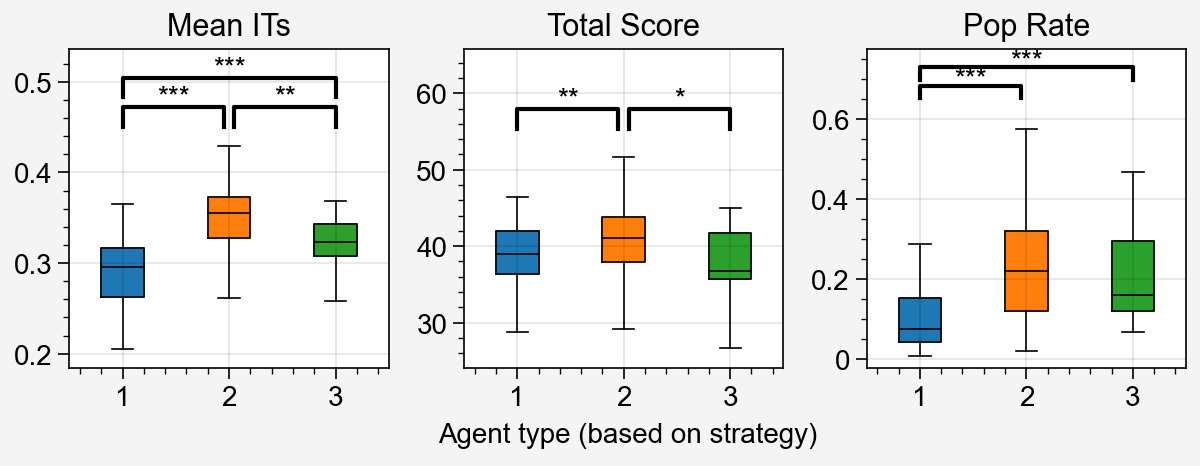

In [10]:
agent_labels = forced_ares['agent_cluster_type']
shaped_labels = agent_labels.reshape(shape)
human_labels = [
    summary['human_bimodal_its'] == 1,
    (summary['human_bimodal_its'] != 1) & (summary['human_exploration'] != 1),
    summary['human_exploration']  == 1
]

fig, ax = pplt.subplots(ncols=3, sharey=False, figwidth=6)
plot_keys = ['human_mean_its', 'human_total_score', 'human_pop_rate']
plot_labels = ['Mean ITs', 'Total Score', 'Pop Rate']
for i in range(3):
    ys = []
    for j in range(3):
        y = summary[plot_keys[i]][human_labels[j]]
        ys.append(y)
        b = ax[i].boxplot(j, y, fliers=False, widths=0.4)
        color_boxplot(b, rgb_colors[j], ax[i])
    ax[i].format(title=plot_labels[i])

    bar_dy_ratio = 3 if i == 3 else None
    lim_dy_ratio = 4.5 if i == 3 else None
    agent_type_significance_test(ys, ax[i], bar_dy_ratio=bar_dy_ratio,
                                 lim_dy_ratio=lim_dy_ratio)

ax.format(xlabel='Agent type (based on strategy)', 
          xlocator=range(3), xformatter=[str(i) for i in range(1, 4)])

## 4.2 Explortion and Bimodal Rates

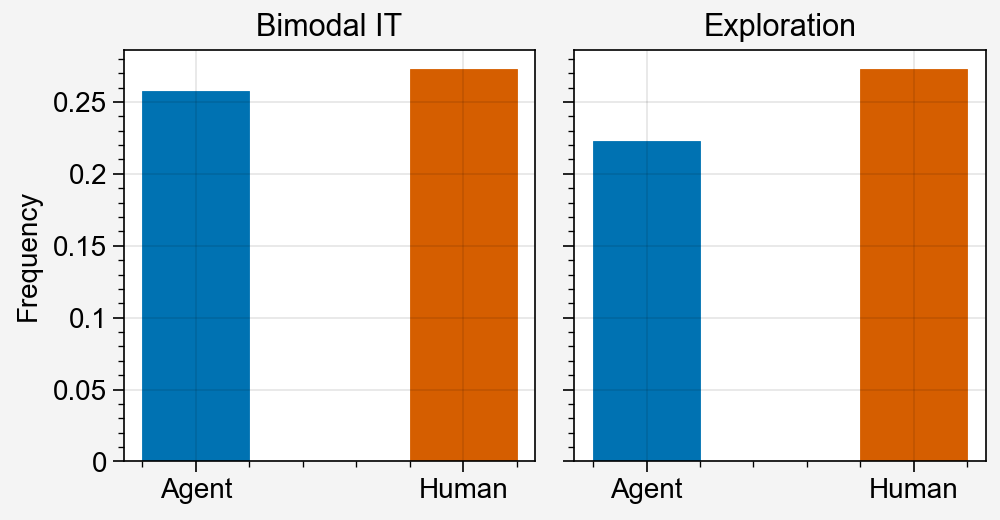

In [43]:
fig, ax = pplt.subplots(ncols=2, figwidth=5)
human_bimodal = 0.272727
human_exploration = 0.272727

ax[0].bar(0, summary['bimodal_its'].mean())
ax[1].bar(0, (summary['gradual_exploration'] > 0.3).mean())

ax[0].bar(1, human_bimodal)
ax[1].bar(1, human_exploration)

ax[0].format(title='Bimodal IT')
ax[1].format(title='Exploration')

ax.format(xlocator=range(2), xformatter=['Agent', 'Human'],
          ylabel='Frequency')

# 5. Representations and Behavior